## CMPINF - 2100 - Final Project - Modelling

## Khan, Rifat 

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Read data 

Load data into notebook

In [2]:
songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

In [3]:
df = pd.read_csv(songs_url)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [5]:
df_copy = df.copy()

In [6]:
df_copy.drop(df_copy[df_copy['speechiness'] == 0].index, inplace=True)
df_copy.head()

track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxury...               2019-06-14   
1                    Memories (Dillon Francis Remix)               2019-12-13   
2                    All the Time (Don Diablo Remix)               2019-07-05   
3                        Call You Mine - The Remixes               2019-07-19   
4            Someone You Loved (Future Humans Remix)               2019-03-05   

  playlist_name             playlist_id playlist_genre  ... key  loudness  \
0     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   6    -2.634   
1     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...  11    -4.969   
2     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   1    -3.432   
3     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   7    -3.778   
4     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   1    -4.672   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1       0.0583        0.1020          0.000000    0.0653    0.518   
1     1       0.0373        0.0724          0.004210    0.3570    0.693   
2     0       0.0742        0.0794          0.000023    0.1100    0.613   
3     1       0.1020        0.0287          0.000009    0.2040    0.277   
4     1       0.0359        0.0803          0.000000    0.0833    0.725   

     tempo  duration_ms  
0  122.036       194754  
1   99.972       162600  
2  124.008       176616  
3  121.956       169093  
4  123.976       189052  

[5 rows x 23 columns]

In [7]:
df_copy['energy'] = np.power(df_copy.energy, 2)
df_copy['acousticness'] = np.power(df_copy.acousticness, 1/4) 
df_copy['liveness'] = np.log(df_copy.liveness) 
df_copy['speechiness'] = np.log(df_copy.speechiness) 

In [8]:
df_copy['mode'] = df_copy['mode'].astype('object')
df_copy['key'] = df_copy['key'].astype('object')

In [9]:
popularity_threshold = df_copy.track_popularity.median()
df_copy['popularity_label'] = np.where(df_copy['track_popularity'] >= popularity_threshold, 1, 0)

In [10]:
df_copy.popularity_label.value_counts(normalize=True)

popularity_label
1    0.51331
0    0.48669
Name: proportion, dtype: float64

Need to re-group values to avoid duplication of tracks, this time including the output for our model. 

Additionally only using features discussed in EDA notebook.

In [11]:
df_modelling = df_copy.groupby(['track_id'], dropna=False).\
aggregate(playlist_genre = ('playlist_genre', 'first'),
          danceability = ('danceability', 'mean'),
          energy = ('energy', 'mean'),
          key = ('key', 'first'),
          mode = ('mode', 'first'),
          acousticness = ('acousticness', 'mean'),
          liveness= ('liveness', 'mean'),
          valence = ('valence', 'mean'),
          duration_ms = ('duration_ms', 'mean'),
          y = ('popularity_label', 'first')).\
reset_index()

df_modelling['y'] = df_modelling.y.astype('category')
num = df_modelling.select_dtypes(include=['number']).columns
categorical = df_modelling.select_dtypes(include=['object', 'category']).columns

Need to standardize the variables

In [12]:
df_modelling[num] = StandardScaler().fit_transform(df_modelling[num])

In [13]:
df_modelling['y'] = df_modelling.y.astype('int64')

## Modelling

Before we start modelling, we shall define some functions before hand for the coefficient plot, assesing the accuracy values and for fitting and assesing the for the ROC curve

In [14]:
def my_coefplot(mod, figsize_use=(10,10)):
    fig, ax = plt.subplots(figsize=figsize_use)
    
    ax.errorbar( y=mod.params.index,
                 x=mod.params,
                 xerr = 2*mod.bse,
                 fmt='o', color='k', ecolor='k', elinewidth=2, ms=10)
   
    ax.axvline(x=0, linestyle='--', linewidth=3.5, color='grey')
    
    ax.set_xlabel('coefficient value')
   
    plt.show()
    

In [15]:
def fit_and_assess_logistic(mod_name, a_formula, train_data, threshold):
    a_mod = smf.logit(formula=a_formula, data = train_data).fit()

    train_copy = train_data.copy()

    train_copy['pred_probability'] = a_mod.predict( train_data )

    train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0)

    TN, FP, FN, TP = confusion_matrix( train_copy.y.to_numpy(), train_copy.pred_class.to_numpy() ).ravel()

    Accuracry = (TN + TP)/(TN +  FP + FN + TP)

    Sensitivity = (TP)/(TP+FN) 

    Specificity = (TN)/(TN+FP)

    FPR = 1 - Specificity

    ROC_AUC = roc_auc_score(train_copy.y.to_numpy(), train_copy.pred_probability.to_numpy() )

    res_dict = {'model_name': mod_name, 
                'model_formula': a_formula,
                'num_coefs' : len(a_mod.params),
                'threshold': threshold,
                'Accuracy' : Accuracry,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity,
                'FPR': FPR,
                'ROC_AUC': ROC_AUC}

    return pd.DataFrame( res_dict, index=[0] )

In [16]:
def fit_logistic_make_roc(mod_name, a_formula, train_data):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()

    train_copy = train_data.copy()

    train_copy['pred_probability'] = a_mod.predict( train_data )

    fpr, tpr, threshold = roc_curve( train_data.y.to_numpy(), train_copy.pred_probability.to_numpy() )

    res_df = pd.DataFrame({'tpr': tpr,
                           'fpr': fpr,
                           'threshold' : threshold})
    res_df['model_name'] = mod_name 
    res_df['model_formula'] = a_formula

    return res_df

### Model 1: Intercept Only Model 

(Consider doing all the models at once as in Week 12 Classification of multiple models **for the main report**)

In [17]:
fit_glm_1 = smf.logit(formula='y ~ 1', data=df_modelling).fit()
fit_glm_1.summary()

Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28354
Method:                           MLE   Df Model:                            0
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:               7.519e-11
Time:                        12:07:34   Log-Likelihood:                -19591.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1341      0.012    -11.269      0.000      -0.157      -0.111
==============================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [18]:
fit_glm_1.params.shape[0]

1

In [19]:
fit_glm_1.bse

Intercept    0.011904
dtype: float64

In [20]:
fit_glm_1.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept -0.157477 -0.110814

In [21]:
fit_glm_1.pvalues 

Intercept    1.867232e-29
dtype: float64

In [22]:
fit_glm_1.pvalues < 0.05

Intercept    True
dtype: bool

Display whether the significant coefficients are positive or negative

In [23]:
pd.Series(np.where(fit_glm_1.params[fit_glm_1.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_1.params[fit_glm_1.pvalues < 0.05].index)

Intercept    NEGATIVE
dtype: object

In [24]:
sorted_series = fit_glm_1.params[fit_glm_1.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_1.params[sorted_series.index]

Intercept   -0.134145
dtype: float64

In [25]:
fit_glm_1.params[sorted_series.index][:min(2, sorted_series.shape[0])]

Intercept   -0.134145
dtype: float64

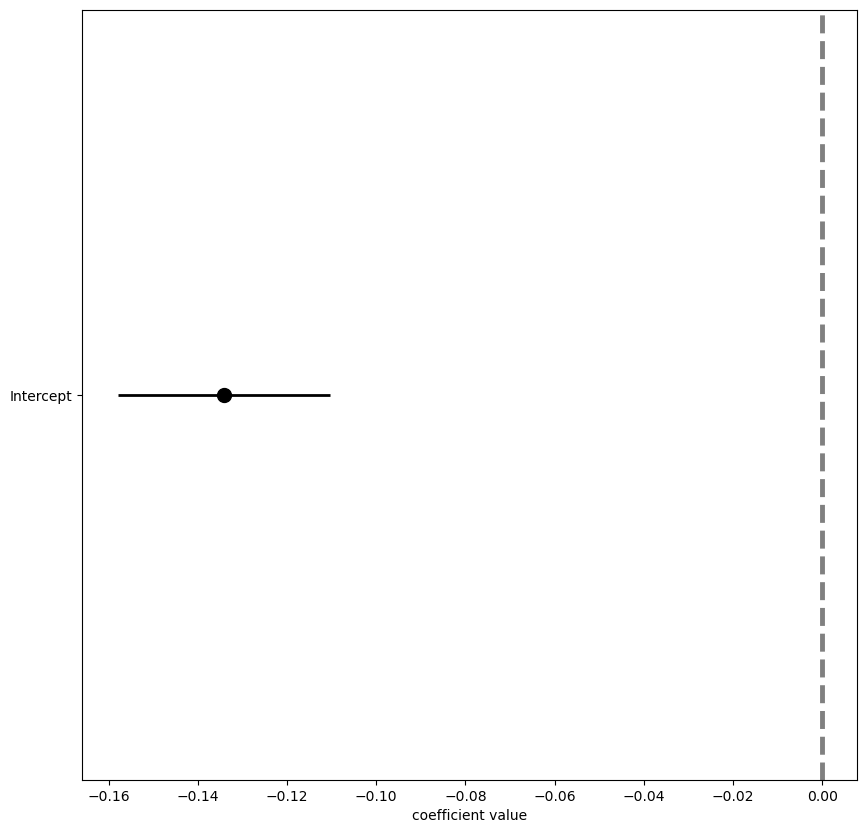

In [26]:
my_coefplot( fit_glm_1 )

Now let us predict using the model and the dataset.

In [27]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_1.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


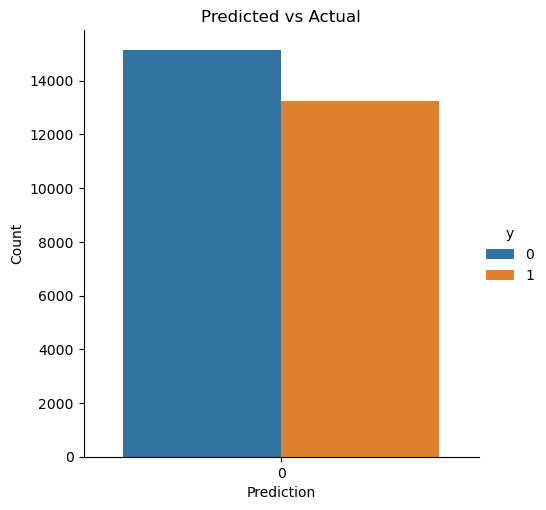

In [28]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

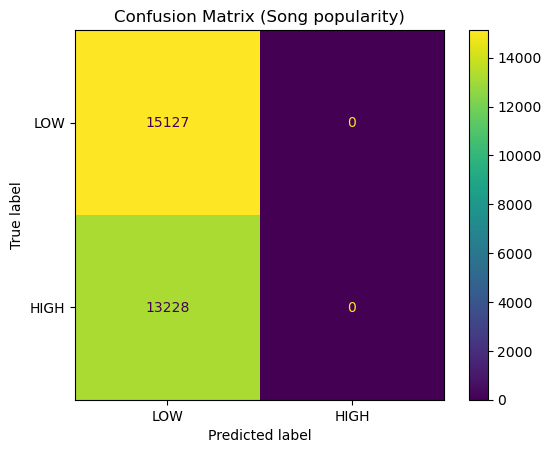

In [29]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [30]:
pred_1 = fit_and_assess_logistic(1, 'y ~ 1', train_data=df_modelling, threshold=0.5)
pred_1

Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 3


model_name model_formula  num_coefs  threshold  Accuracy  Sensitivity  \
0           1         y ~ 1          1        0.5  0.533486          0.0   

   Specificity  FPR  ROC_AUC  
0          1.0  0.0      0.5

Let's create the ROC Curve

In [31]:
ROC_1 = fit_logistic_make_roc(1, 'y ~ 1', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 3


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


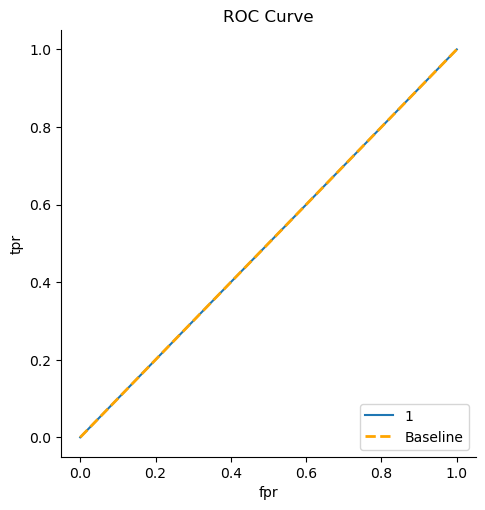

In [32]:
g = sns.relplot(data = ROC_1, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None)
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

### Model 2: Categorical inputs with linear additive features

In [33]:
fit_glm_2 = smf.logit(formula='y ~ key + mode + playlist_genre', data=df_modelling).fit()
fit_glm_2.summary()

Optimization terminated successfully.
         Current function value: 0.669858
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28337
Method:                           MLE   Df Model:                           17
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.03046
Time:                        12:07:35   Log-Likelihood:                -18994.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                3.295e-243
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.9444      0.051    -18.484      0.000      -1.044      -0.844
key[T.1]                   -0.0330      0.051     -0.644      0.520      -0.134       0.067
key[T.2]                   -0.1166      0.056     -2.097      0.036      -0.226      -0.008
key[T.3]                   -0.0379      0.082     -0.462      0.644      -0.199       0.123
key[T.4]                   -0.0878      0.060     -1.452      0.146      -0.206       0.031
key[T.5]                    0.0478      0.057      0.834      0.404      -0.064       0.160
key[T.6]                   -0.0475      0.057     -0.826      0.409      -0.160       0.065
key[T.7]                   -0.1239      0.053     -2.325      0.020      -0.228      -0.019
key[T.8]                    0.1485      0.059      2.538      0.011       0.034       0.263
key[T.9]                   -0.0965      0.055     -1.760      0.078      -0.204       0.011
key[T.10]                   0.0124      0.060      0.207      0.836      -0.105       0.130
key[T.11]                  -0.0691      0.056     -1.239      0.215      -0.178       0.040
mode[T.1]                   0.0115      0.026      0.444      0.657      -0.039       0.062
playlist_genre[T.latin]     1.0337      0.045     23.086      0.000       0.946       1.121
playlist_genre[T.pop]       1.2517      0.043     29.232      0.000       1.168       1.336
playlist_genre[T.r&b]       0.6211      0.044     14.067      0.000       0.535       0.708
playlist_genre[T.rap]       1.0803      0.042     25.591      0.000       0.998       1.163
playlist_genre[T.rock]      0.9689      0.045     21.645      0.000       0.881       1.057
===========================================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [34]:
fit_glm_2.params.shape[0]

18

In [35]:
fit_glm_2.bse

Intercept                  0.051091
key[T.1]                   0.051279
key[T.2]                   0.055605
key[T.3]                   0.082028
key[T.4]                   0.060457
key[T.5]                   0.057266
key[T.6]                   0.057478
key[T.7]                   0.053292
key[T.8]                   0.058501
key[T.9]                   0.054801
key[T.10]                  0.060050
key[T.11]                  0.055767
mode[T.1]                  0.025970
playlist_genre[T.latin]    0.044774
playlist_genre[T.pop]      0.042819
playlist_genre[T.r&b]      0.044153
playlist_genre[T.rap]      0.042214
playlist_genre[T.rock]     0.044763
dtype: float64

In [36]:
fit_glm_2.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept               -1.044492 -0.844218
key[T.1]                -0.133526  0.067483
key[T.2]                -0.225589 -0.007622
key[T.3]                -0.198682  0.122861
key[T.4]                -0.206292  0.030697
key[T.5]                -0.064466  0.160012
key[T.6]                -0.160115  0.065194
key[T.7]                -0.228357 -0.019457
key[T.8]                 0.033793  0.263114
key[T.9]                -0.203862  0.010953
key[T.10]               -0.105251  0.130142
key[T.11]               -0.178416  0.040185
mode[T.1]               -0.039376  0.062424
playlist_genre[T.latin]  0.945906  1.121416
playlist_genre[T.pop]    1.167771  1.335619
playlist_genre[T.r&b]    0.534560  0.707635
playlist_genre[T.rap]    0.997541  1.163017
playlist_genre[T.rock]   0.881178  1.056646

In [37]:
fit_glm_2.pvalues 

Intercept                   2.793905e-76
key[T.1]                    5.195990e-01
key[T.2]                    3.599045e-02
key[T.3]                    6.439647e-01
key[T.4]                    1.464401e-01
key[T.5]                    4.041544e-01
key[T.6]                    4.089655e-01
key[T.7]                    2.006879e-02
key[T.8]                    1.116143e-02
key[T.9]                    7.839211e-02
key[T.10]                   8.358146e-01
key[T.11]                   2.152094e-01
mode[T.1]                   6.572208e-01
playlist_genre[T.latin]    6.352526e-118
playlist_genre[T.pop]      7.589133e-188
playlist_genre[T.r&b]       6.055070e-45
playlist_genre[T.rap]      1.939831e-144
playlist_genre[T.rock]     6.717179e-104
dtype: float64

In [38]:
fit_glm_2.pvalues < 0.05

Intercept                   True
key[T.1]                   False
key[T.2]                    True
key[T.3]                   False
key[T.4]                   False
key[T.5]                   False
key[T.6]                   False
key[T.7]                    True
key[T.8]                    True
key[T.9]                   False
key[T.10]                  False
key[T.11]                  False
mode[T.1]                  False
playlist_genre[T.latin]     True
playlist_genre[T.pop]       True
playlist_genre[T.r&b]       True
playlist_genre[T.rap]       True
playlist_genre[T.rock]      True
dtype: bool

Display whether the significant coefficients are positive or negative

In [39]:
pd.Series(np.where(fit_glm_2.params[fit_glm_2.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_2.params[fit_glm_2.pvalues < 0.05].index)

Intercept                  NEGATIVE
key[T.2]                   NEGATIVE
key[T.7]                   NEGATIVE
key[T.8]                   POSITIVE
playlist_genre[T.latin]    POSITIVE
playlist_genre[T.pop]      POSITIVE
playlist_genre[T.r&b]      POSITIVE
playlist_genre[T.rap]      POSITIVE
playlist_genre[T.rock]     POSITIVE
dtype: object

In [40]:
sorted_series = fit_glm_2.params[fit_glm_2.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_2.params[sorted_series.index]

playlist_genre[T.pop]      1.251695
playlist_genre[T.rap]      1.080279
playlist_genre[T.latin]    1.033661
playlist_genre[T.rock]     0.968912
Intercept                 -0.944355
playlist_genre[T.r&b]      0.621098
key[T.8]                   0.148453
key[T.7]                  -0.123907
key[T.2]                  -0.116606
dtype: float64

In [41]:
fit_glm_2.params[sorted_series.index][:min(2, sorted_series.shape[0])]

playlist_genre[T.pop]    1.251695
playlist_genre[T.rap]    1.080279
dtype: float64

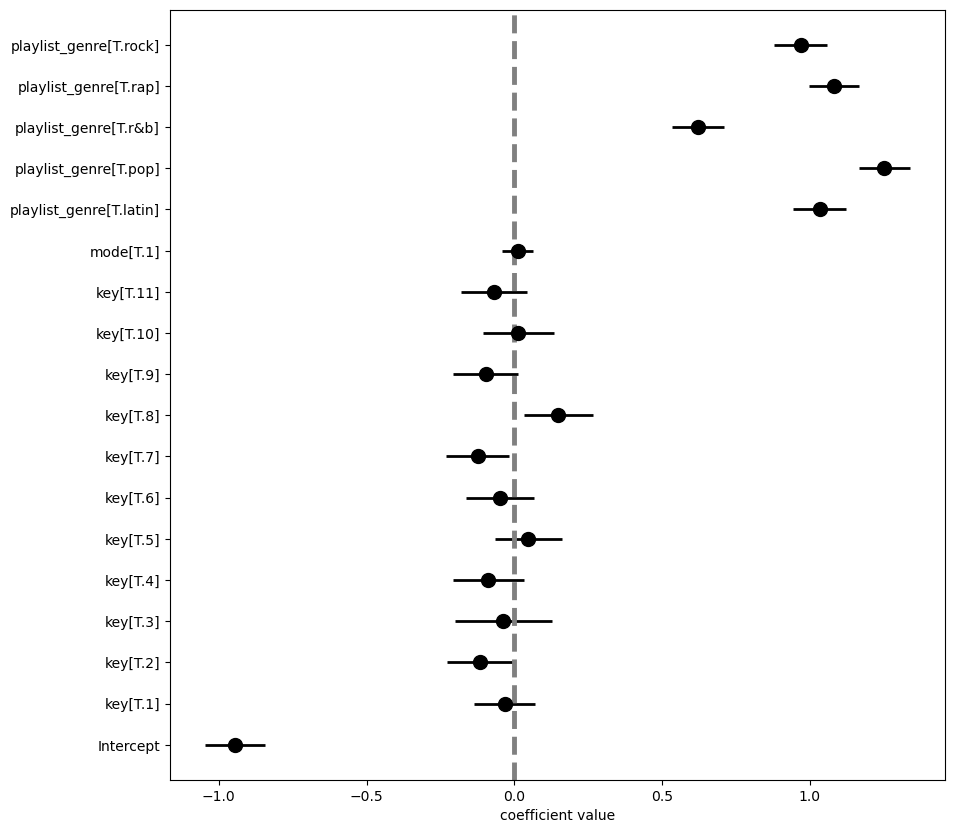

In [42]:
my_coefplot( fit_glm_2 )

Now let us predict using the model and the dataset.

In [43]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_2.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


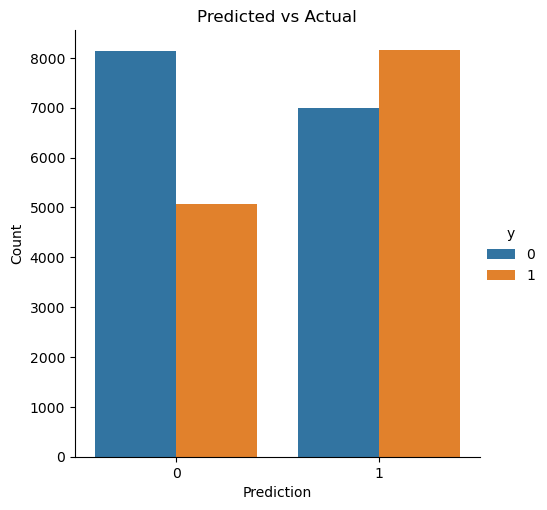

In [44]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

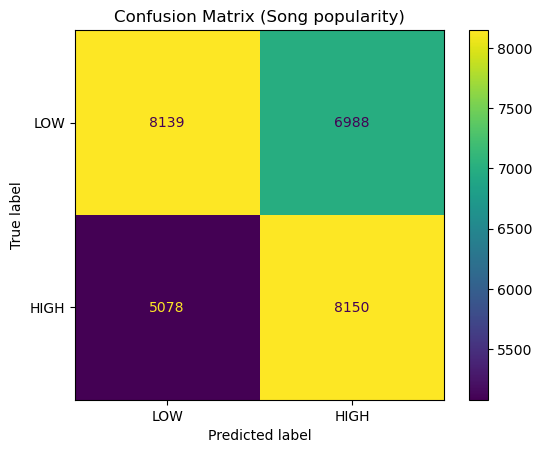

In [45]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [46]:
pred_2 = fit_and_assess_logistic(2, 'y ~ key + mode + playlist_genre', train_data=df_modelling, threshold=0.5)
pred_2

Optimization terminated successfully.
         Current function value: 0.669858
         Iterations 5


model_name                    model_formula  num_coefs  threshold  \
0           2  y ~ key + mode + playlist_genre         18        0.5   

   Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
0  0.574467     0.616117     0.538045  0.461955  0.608519

Let's create the ROC Curve

In [47]:
ROC_2 = fit_logistic_make_roc(2, 'y ~ key + mode + playlist_genre', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.669858
         Iterations 5


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


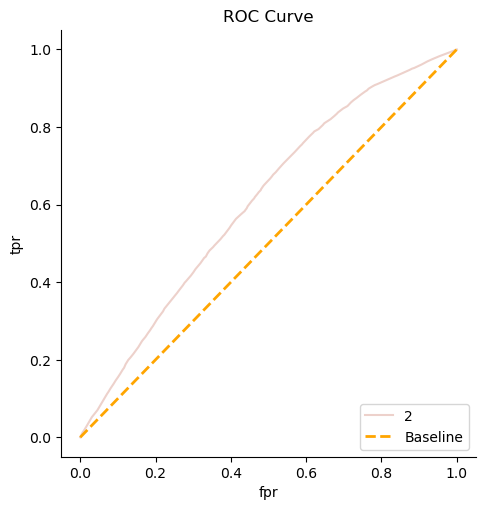

In [48]:
g = sns.relplot(data = ROC_2, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

### Model 3: Continous inputs with linear additive features

In [49]:
fit_glm_3 = smf.logit(formula='y ~ danceability + energy + acousticness + liveness + valence + duration_ms', data=df_modelling).fit()
fit_glm_3.summary()

Optimization terminated successfully.
         Current function value: 0.678538
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28348
Method:                           MLE   Df Model:                            6
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.01790
Time:                        12:07:36   Log-Likelihood:                -19240.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                3.390e-148
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1383      0.012    -11.471      0.000      -0.162      -0.115
danceability    -0.0099      0.013     -0.753      0.451      -0.036       0.016
energy          -0.1259      0.015     -8.557      0.000      -0.155      -0.097
acousticness     0.1313      0.014      9.114      0.000       0.103       0.159
liveness        -0.0292      0.012     -2.367      0.018      -0.053      -0.005
valence          0.0648      0.013      4.905      0.000       0.039       0.091
duration_ms     -0.2071      0.013    -16.418      0.000      -0.232      -0.182
================================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [50]:
fit_glm_3.params.shape[0]

7

In [51]:
fit_glm_3.bse

Intercept       0.012057
danceability    0.013159
energy          0.014715
acousticness    0.014401
liveness        0.012337
valence         0.013218
duration_ms     0.012613
dtype: float64

In [52]:
fit_glm_3.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept    -0.161931 -0.114669
danceability -0.035701  0.015883
energy       -0.154753 -0.097073
acousticness  0.103032  0.159483
liveness     -0.053385 -0.005023
valence       0.038931  0.090746
duration_ms  -0.231794 -0.182353

In [53]:
fit_glm_3.pvalues 

Intercept       1.850974e-30
danceability    4.514445e-01
energy          1.157880e-17
acousticness    7.916931e-20
liveness        1.792668e-02
valence         9.330087e-07
duration_ms     1.422456e-60
dtype: float64

In [54]:
fit_glm_3.pvalues < 0.05

Intercept        True
danceability    False
energy           True
acousticness     True
liveness         True
valence          True
duration_ms      True
dtype: bool

Display whether the significant coefficients are positive or negative

In [55]:
pd.Series(np.where(fit_glm_3.params[fit_glm_3.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_3.params[fit_glm_3.pvalues < 0.05].index)

Intercept       NEGATIVE
energy          NEGATIVE
acousticness    POSITIVE
liveness        NEGATIVE
valence         POSITIVE
duration_ms     NEGATIVE
dtype: object

In [56]:
sorted_series = fit_glm_3.params[fit_glm_3.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_3.params[sorted_series.index]

duration_ms    -0.207073
Intercept      -0.138300
acousticness    0.131257
energy         -0.125913
valence         0.064839
liveness       -0.029204
dtype: float64

In [57]:
fit_glm_3.params[sorted_series.index][:min(2, sorted_series.shape[0])]

duration_ms   -0.207073
Intercept     -0.138300
dtype: float64

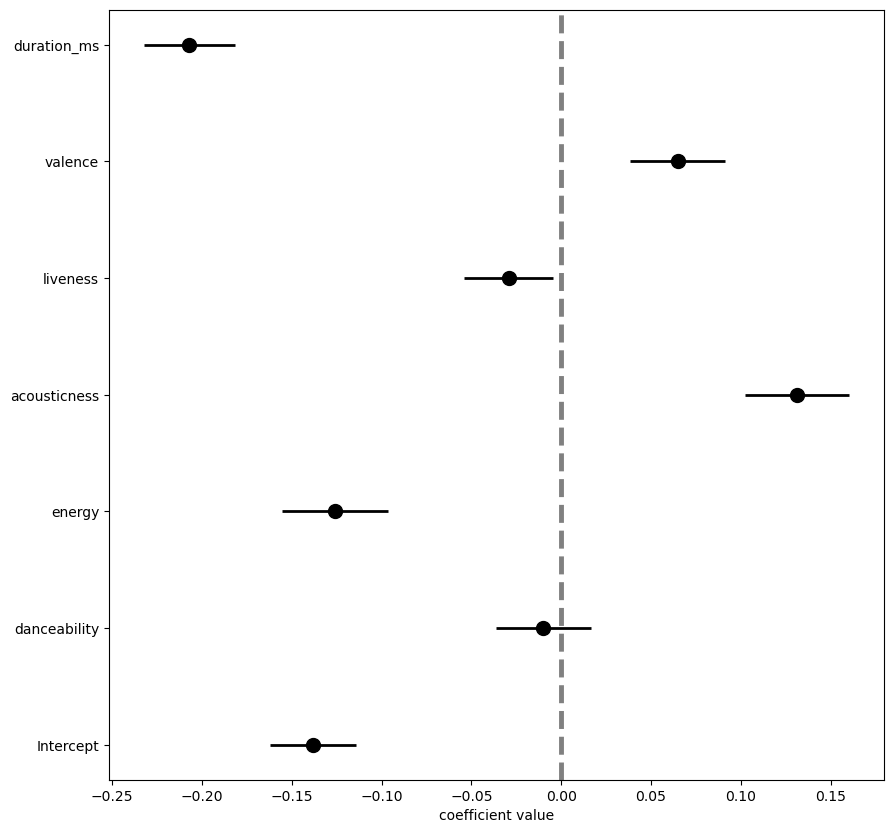

In [58]:
my_coefplot( fit_glm_3 )

In [59]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_3.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


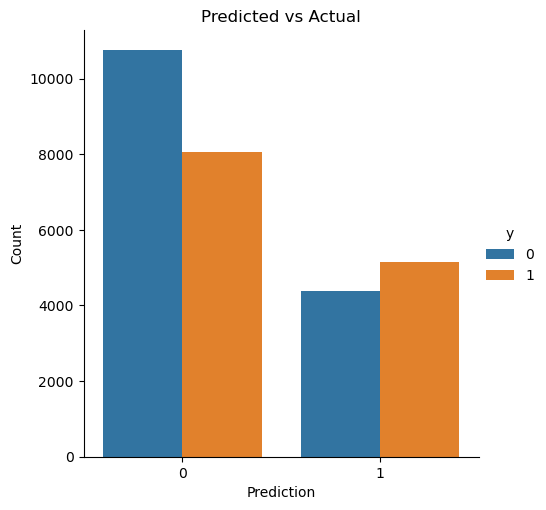

In [60]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

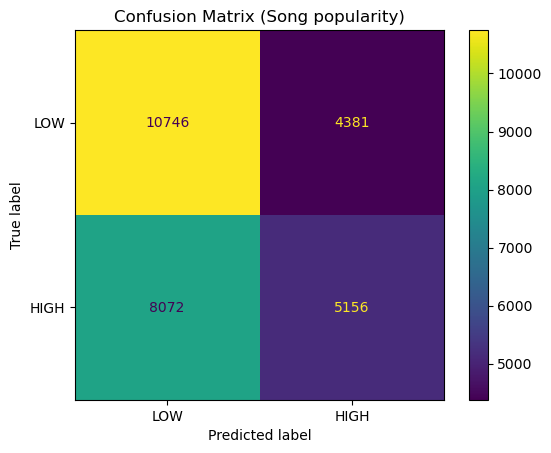

In [61]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [62]:
pred_3 = fit_and_assess_logistic(3, 'y ~ danceability + energy + acousticness + liveness + valence + duration_ms', train_data=df_modelling, threshold=0.5)
pred_3

Optimization terminated successfully.
         Current function value: 0.678538
         Iterations 4


model_name                                      model_formula  num_coefs  \
0           3  y ~ danceability + energy + acousticness + liv...          7   

   threshold  Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
0        0.5  0.560818     0.389779     0.710385  0.289615  0.586903

Let's create the ROC Curve

In [63]:
ROC_3 = fit_logistic_make_roc(3, 'y ~ danceability + energy + acousticness + liveness + valence + duration_ms', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.678538
         Iterations 4


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


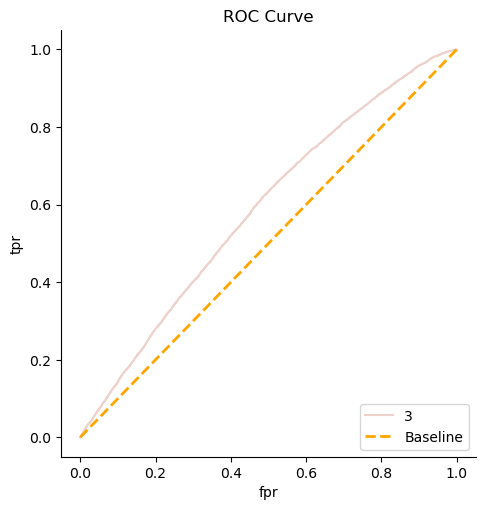

In [64]:
g = sns.relplot(data = ROC_3, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

### Model 4: All inputs with linear additive features

In [65]:
fit_glm_4 = smf.logit(formula='y ~ key + mode + playlist_genre + danceability + energy + acousticness + liveness + valence + duration_ms', data=df_modelling).fit()
fit_glm_4.summary()

Optimization terminated successfully.
         Current function value: 0.661513
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28331
Method:                           MLE   Df Model:                           23
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.04254
Time:                        12:07:37   Log-Likelihood:                -18757.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.8899      0.053    -16.890      0.000      -0.993      -0.787
key[T.1]                   -0.0044      0.052     -0.085      0.932      -0.106       0.097
key[T.2]                   -0.0857      0.056     -1.527      0.127      -0.196       0.024
key[T.3]                   -0.0463      0.083     -0.559      0.576      -0.208       0.116
key[T.4]                   -0.0714      0.061     -1.171      0.242      -0.191       0.048
key[T.5]                    0.0642      0.058      1.112      0.266      -0.049       0.177
key[T.6]                   -0.0014      0.058     -0.024      0.981      -0.115       0.112
key[T.7]                   -0.0931      0.054     -1.731      0.083      -0.198       0.012
key[T.8]                    0.1608      0.059      2.724      0.006       0.045       0.277
key[T.9]                   -0.0768      0.055     -1.390      0.164      -0.185       0.031
key[T.10]                   0.0318      0.061      0.524      0.600      -0.087       0.151
key[T.11]                  -0.0259      0.056     -0.461      0.645      -0.136       0.084
mode[T.1]                   0.0107      0.026      0.407      0.684      -0.041       0.062
playlist_genre[T.latin]     0.8751      0.048     18.245      0.000       0.781       0.969
playlist_genre[T.pop]       1.1562      0.045     25.741      0.000       1.068       1.244
playlist_genre[T.r&b]       0.4865      0.049      9.863      0.000       0.390       0.583
playlist_genre[T.rap]       0.8874      0.045     19.652      0.000       0.799       0.976
playlist_genre[T.rock]      1.0891      0.050     21.742      0.000       0.991       1.187
danceability                0.0738      0.015      4.893      0.000       0.044       0.103
energy                     -0.0658      0.016     -4.171      0.000      -0.097      -0.035
acousticness                0.1228      0.015      8.238      0.000       0.094       0.152
liveness                   -0.0191      0.013     -1.509      0.131      -0.044       0.006
valence                    -0.0306      0.014     -2.136      0.033      -0.059      -0.003
duration_ms                -0.2015      0.013    -15.306      0.000      -0.227      -0.176
===========================================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [66]:
fit_glm_4.params.shape[0]

24

In [67]:
fit_glm_4.bse

Intercept                  0.052684
key[T.1]                   0.051824
key[T.2]                   0.056102
key[T.3]                   0.082745
key[T.4]                   0.060992
key[T.5]                   0.057733
key[T.6]                   0.058047
key[T.7]                   0.053765
key[T.8]                   0.059027
key[T.9]                   0.055240
key[T.10]                  0.060586
key[T.11]                  0.056280
mode[T.1]                  0.026179
playlist_genre[T.latin]    0.047962
playlist_genre[T.pop]      0.044917
playlist_genre[T.r&b]      0.049332
playlist_genre[T.rap]      0.045158
playlist_genre[T.rock]     0.050089
danceability               0.015076
energy                     0.015778
acousticness               0.014903
liveness                   0.012627
valence                    0.014346
duration_ms                0.013165
dtype: float64

In [68]:
fit_glm_4.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept               -0.993111 -0.786592
key[T.1]                -0.105985  0.097161
key[T.2]                -0.195650  0.024264
key[T.3]                -0.208466  0.115888
key[T.4]                -0.190952  0.048132
key[T.5]                -0.048960  0.177348
key[T.6]                -0.115139  0.112399
key[T.7]                -0.198447  0.012309
key[T.8]                 0.045122  0.276504
key[T.9]                -0.185073  0.031466
key[T.10]               -0.086984  0.150510
key[T.11]               -0.136253  0.084359
mode[T.1]               -0.040643  0.061975
playlist_genre[T.latin]  0.781084  0.969092
playlist_genre[T.pop]    1.068163  1.244236
playlist_genre[T.r&b]    0.389861  0.583237
playlist_genre[T.rap]    0.798931  0.975946
playlist_genre[T.rock]   0.990883  1.187229
danceability             0.044222  0.103317
energy                  -0.096730 -0.034881
acousticness             0.093561  0.151981
liveness                -0.043802  0.005695
valence                 -0.058765 -0.002529
duration_ms             -0.227309 -0.175702

In [69]:
fit_glm_4.pvalues 

Intercept                   5.311354e-64
key[T.1]                    9.321554e-01
key[T.2]                    1.266446e-01
key[T.3]                    5.758774e-01
key[T.4]                    2.416757e-01
key[T.5]                    2.661756e-01
key[T.6]                    9.811699e-01
key[T.7]                    8.344626e-02
key[T.8]                    6.442023e-03
key[T.9]                    1.644217e-01
key[T.10]                   6.000987e-01
key[T.11]                   6.447733e-01
mode[T.1]                   6.836952e-01
playlist_genre[T.latin]     2.249270e-74
playlist_genre[T.pop]      4.099209e-146
playlist_genre[T.r&b]       6.031687e-23
playlist_genre[T.rap]       5.560140e-86
playlist_genre[T.rock]     8.168614e-105
danceability                9.914525e-07
energy                      3.036658e-05
acousticness                1.753231e-16
liveness                    1.313078e-01
valence                     3.266089e-02
duration_ms                 6.974128e-53
dtype: float64

In [70]:
fit_glm_4.pvalues < 0.05

Intercept                   True
key[T.1]                   False
key[T.2]                   False
key[T.3]                   False
key[T.4]                   False
key[T.5]                   False
key[T.6]                   False
key[T.7]                   False
key[T.8]                    True
key[T.9]                   False
key[T.10]                  False
key[T.11]                  False
mode[T.1]                  False
playlist_genre[T.latin]     True
playlist_genre[T.pop]       True
playlist_genre[T.r&b]       True
playlist_genre[T.rap]       True
playlist_genre[T.rock]      True
danceability                True
energy                      True
acousticness                True
liveness                   False
valence                     True
duration_ms                 True
dtype: bool

Display whether the significant coefficients are positive or negative

In [71]:
pd.Series(np.where(fit_glm_4.params[fit_glm_4.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_4.params[fit_glm_4.pvalues < 0.05].index)

Intercept                  NEGATIVE
key[T.8]                   POSITIVE
playlist_genre[T.latin]    POSITIVE
playlist_genre[T.pop]      POSITIVE
playlist_genre[T.r&b]      POSITIVE
playlist_genre[T.rap]      POSITIVE
playlist_genre[T.rock]     POSITIVE
danceability               POSITIVE
energy                     NEGATIVE
acousticness               POSITIVE
valence                    NEGATIVE
duration_ms                NEGATIVE
dtype: object

In [72]:
sorted_series = fit_glm_4.params[fit_glm_4.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_4.params[sorted_series.index]

playlist_genre[T.pop]      1.156200
playlist_genre[T.rock]     1.089056
Intercept                 -0.889852
playlist_genre[T.rap]      0.887439
playlist_genre[T.latin]    0.875088
playlist_genre[T.r&b]      0.486549
duration_ms               -0.201505
key[T.8]                   0.160813
acousticness               0.122771
danceability               0.073770
energy                    -0.065805
valence                   -0.030647
dtype: float64

In [73]:
fit_glm_4.params[sorted_series.index][:min(2, sorted_series.shape[0])]

playlist_genre[T.pop]     1.156200
playlist_genre[T.rock]    1.089056
dtype: float64

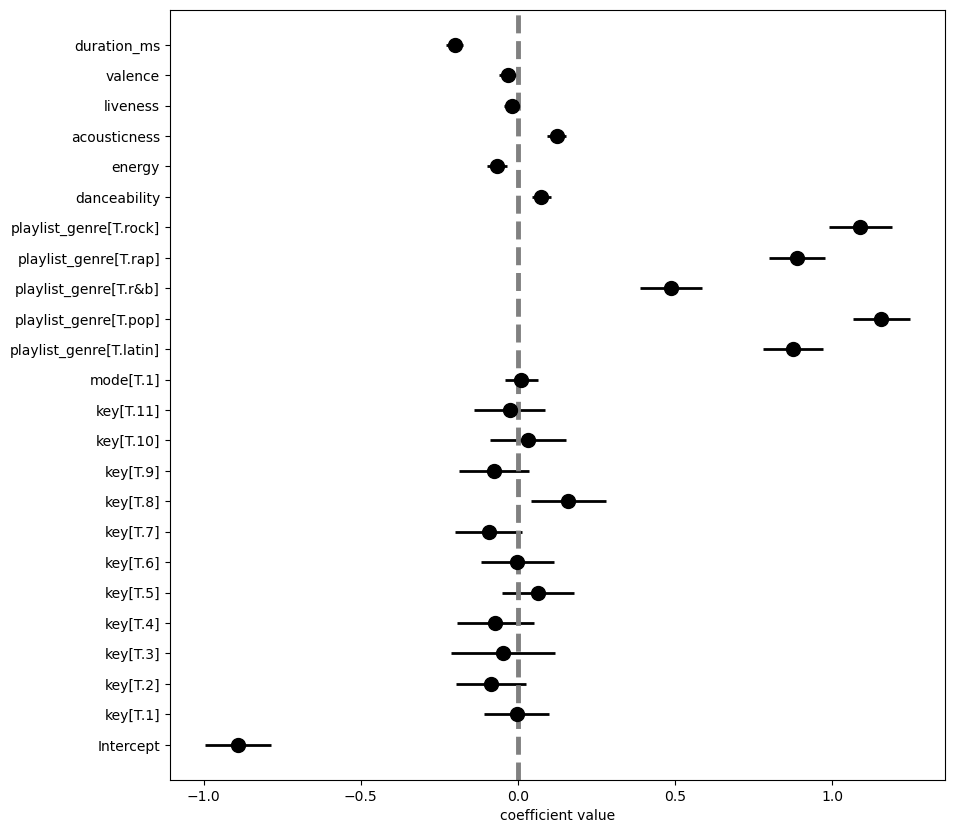

In [74]:
my_coefplot( fit_glm_4 )

Now let us predict using the model and the dataset.

In [75]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_4.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


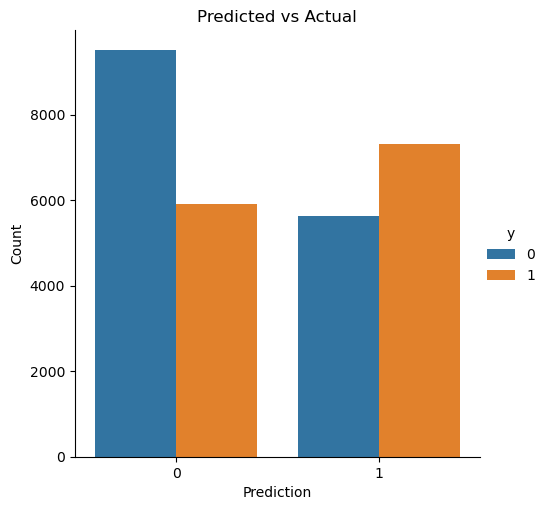

In [76]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

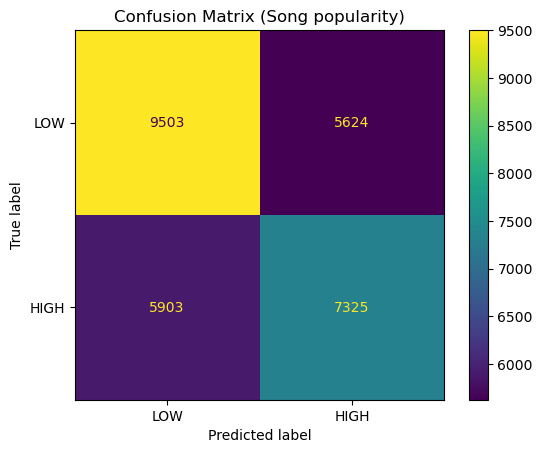

In [77]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [78]:
pred_4 = fit_and_assess_logistic(4, 'y ~ key + mode + playlist_genre + danceability + energy + acousticness + liveness + valence + duration_ms', train_data=df_modelling, threshold=0.5)
pred_4

Optimization terminated successfully.
         Current function value: 0.661513
         Iterations 5


model_name                                      model_formula  num_coefs  \
0           4  y ~ key + mode + playlist_genre + danceability...         24   

   threshold  Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
0        0.5  0.593476      0.55375     0.628214  0.371786  0.631902

Let's create the ROC Curve

In [79]:
ROC_4 = fit_logistic_make_roc(4, 'y ~ key + mode + playlist_genre + danceability + energy + acousticness + liveness + valence + duration_ms', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.661513
         Iterations 5


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


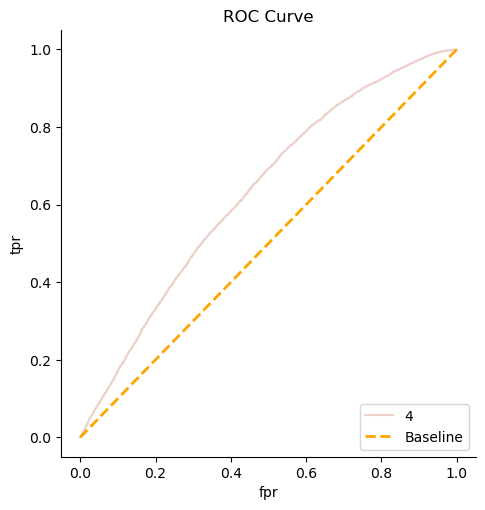

In [80]:
g = sns.relplot(data = ROC_4, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

### Model 5: Continous inputs with linear main effect and pair-wise interactions

In [81]:
fit_glm_5 = smf.logit(formula='y ~ (danceability + energy + acousticness + liveness + valence + duration_ms)**2', data=df_modelling).fit()
fit_glm_5.summary()

Optimization terminated successfully.
         Current function value: 0.673991
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28333
Method:                           MLE   Df Model:                           21
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.02448
Time:                        12:07:39   Log-Likelihood:                -19111.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                1.456e-189
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.1337      0.015     -8.839      0.000      -0.163      -0.104
danceability                 -0.0004      0.014     -0.026      0.979      -0.028       0.027
energy                       -0.1238      0.015     -8.164      0.000      -0.153      -0.094
acousticness                  0.1387      0.015      9.269      0.000       0.109       0.168
liveness                     -0.0317      0.013     -2.465      0.014      -0.057      -0.007
valence                       0.0525      0.014      3.863      0.000       0.026       0.079
duration_ms                  -0.2101      0.013    -16.050      0.000      -0.236      -0.184
danceability:energy          -0.0423      0.016     -2.704      0.007      -0.073      -0.012
danceability:acousticness     0.0999      0.015      6.596      0.000       0.070       0.130
danceability:liveness         0.0479      0.013      3.621      0.000       0.022       0.074
danceability:valence          0.0151      0.013      1.152      0.250      -0.011       0.041
danceability:duration_ms     -0.0727      0.012     -5.914      0.000      -0.097      -0.049
energy:acousticness           0.0472      0.013      3.675      0.000       0.022       0.072
energy:liveness               0.0041      0.015      0.277      0.782      -0.025       0.033
energy:valence                0.0674      0.015      4.440      0.000       0.038       0.097
energy:duration_ms            0.0054      0.015      0.362      0.718      -0.024       0.035
acousticness:liveness         0.0040      0.015      0.270      0.787      -0.025       0.033
acousticness:valence         -0.0837      0.015     -5.451      0.000      -0.114      -0.054
acousticness:duration_ms      0.0489      0.014      3.399      0.001       0.021       0.077
liveness:valence              0.0056      0.014      0.410      0.682      -0.021       0.033
liveness:duration_ms          0.0393      0.013      3.089      0.002       0.014       0.064
valence:duration_ms          -0.0136      0.013     -1.027      0.305      -0.040       0.012
=============================================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [82]:
fit_glm_5.params.shape[0]

22

In [83]:
fit_glm_5.bse

Intercept                    0.015129
danceability                 0.013947
energy                       0.015159
acousticness                 0.014967
liveness                     0.012875
valence                      0.013593
duration_ms                  0.013088
danceability:energy          0.015653
danceability:acousticness    0.015149
danceability:liveness        0.013234
danceability:valence         0.013147
danceability:duration_ms     0.012288
energy:acousticness          0.012854
energy:liveness              0.014740
energy:valence               0.015182
energy:duration_ms           0.014889
acousticness:liveness        0.014751
acousticness:valence         0.015361
acousticness:duration_ms     0.014392
liveness:valence             0.013732
liveness:duration_ms         0.012709
valence:duration_ms          0.013229
dtype: float64

In [84]:
fit_glm_5.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept                 -0.163386 -0.104081
danceability              -0.027695  0.026976
energy                    -0.153467 -0.094044
acousticness               0.109393  0.168063
liveness                  -0.056971 -0.006502
valence                    0.025863  0.079147
duration_ms               -0.235715 -0.184412
danceability:energy       -0.073011 -0.011653
danceability:acousticness  0.070238  0.129622
danceability:liveness      0.021977  0.073853
danceability:valence      -0.010628  0.040908
danceability:duration_ms  -0.096754 -0.048585
energy:acousticness        0.022049  0.072434
energy:liveness           -0.024807  0.032972
energy:valence             0.037652  0.097166
energy:duration_ms        -0.023798  0.034565
acousticness:liveness     -0.024934  0.032888
acousticness:valence      -0.113838 -0.053626
acousticness:duration_ms   0.020709  0.077123
liveness:valence          -0.021282  0.032545
liveness:duration_ms       0.014346  0.064165
valence:duration_ms       -0.039510  0.012347

In [85]:
fit_glm_5.pvalues 

Intercept                    9.623576e-19
danceability                 9.794457e-01
energy                       3.246671e-16
acousticness                 1.883103e-20
liveness                     1.370125e-02
valence                      1.121853e-04
duration_ms                  5.675731e-58
danceability:energy          6.841554e-03
danceability:acousticness    4.211998e-11
danceability:liveness        2.938709e-04
danceability:valence         2.495003e-01
danceability:duration_ms     3.345299e-09
energy:acousticness          2.375026e-04
energy:liveness              7.817913e-01
energy:valence               8.998898e-06
energy:duration_ms           7.176742e-01
acousticness:liveness        7.874419e-01
acousticness:valence         5.006567e-08
acousticness:duration_ms     6.765027e-04
liveness:valence             6.817071e-01
liveness:duration_ms         2.010214e-03
valence:duration_ms          3.045872e-01
dtype: float64

In [86]:
fit_glm_5.pvalues < 0.05

Intercept                     True
danceability                 False
energy                        True
acousticness                  True
liveness                      True
valence                       True
duration_ms                   True
danceability:energy           True
danceability:acousticness     True
danceability:liveness         True
danceability:valence         False
danceability:duration_ms      True
energy:acousticness           True
energy:liveness              False
energy:valence                True
energy:duration_ms           False
acousticness:liveness        False
acousticness:valence          True
acousticness:duration_ms      True
liveness:valence             False
liveness:duration_ms          True
valence:duration_ms          False
dtype: bool

Display whether the significant coefficients are positive or negative

In [87]:
pd.Series(np.where(fit_glm_5.params[fit_glm_5.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_5.params[fit_glm_5.pvalues < 0.05].index)

Intercept                    NEGATIVE
energy                       NEGATIVE
acousticness                 POSITIVE
liveness                     NEGATIVE
valence                      POSITIVE
duration_ms                  NEGATIVE
danceability:energy          NEGATIVE
danceability:acousticness    POSITIVE
danceability:liveness        POSITIVE
danceability:duration_ms     NEGATIVE
energy:acousticness          POSITIVE
energy:valence               POSITIVE
acousticness:valence         NEGATIVE
acousticness:duration_ms     POSITIVE
liveness:duration_ms         POSITIVE
dtype: object

In [88]:
sorted_series = fit_glm_5.params[fit_glm_5.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_5.params[sorted_series.index]

duration_ms                 -0.210064
acousticness                 0.138728
Intercept                   -0.133733
energy                      -0.123756
danceability:acousticness    0.099930
acousticness:valence        -0.083732
danceability:duration_ms    -0.072670
energy:valence               0.067409
valence                      0.052505
acousticness:duration_ms     0.048916
danceability:liveness        0.047915
energy:acousticness          0.047242
danceability:energy         -0.042332
liveness:duration_ms         0.039255
liveness                    -0.031737
dtype: float64

In [89]:
fit_glm_5.params[sorted_series.index][:min(2, sorted_series.shape[0])]

duration_ms    -0.210064
acousticness    0.138728
dtype: float64

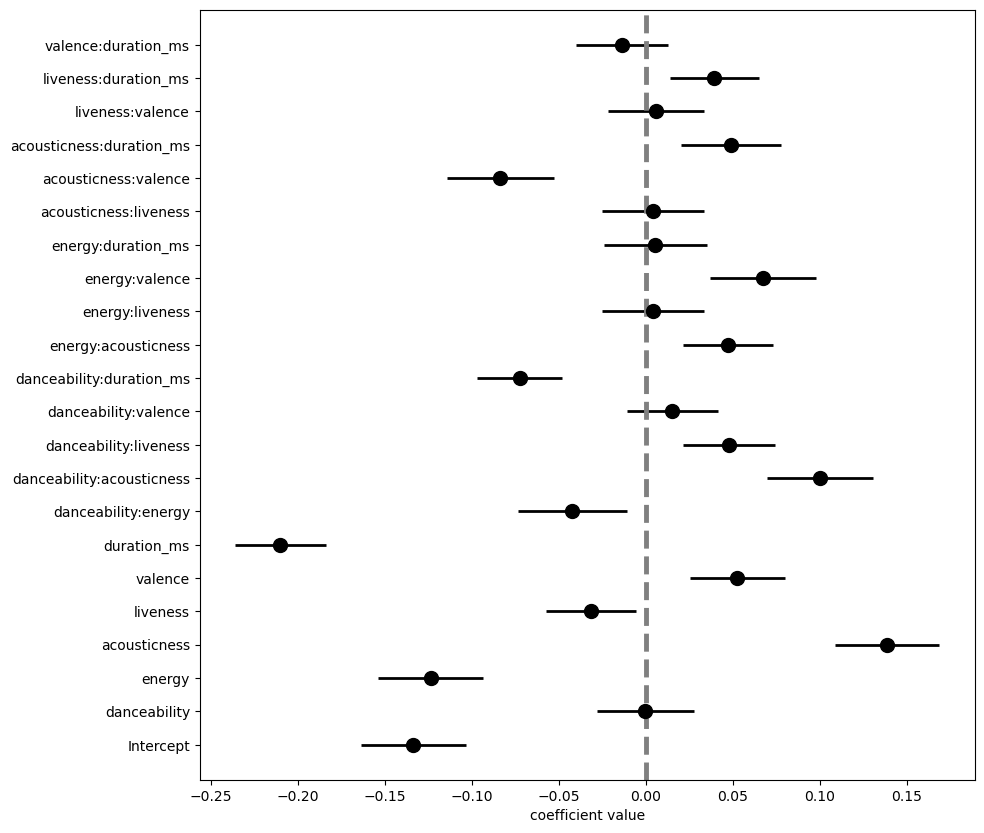

In [90]:
my_coefplot( fit_glm_5 )

Now let us predict using the model and the dataset.

In [91]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_5.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


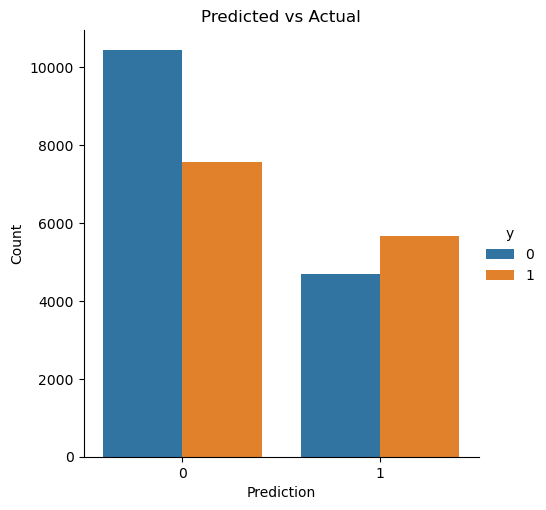

In [92]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

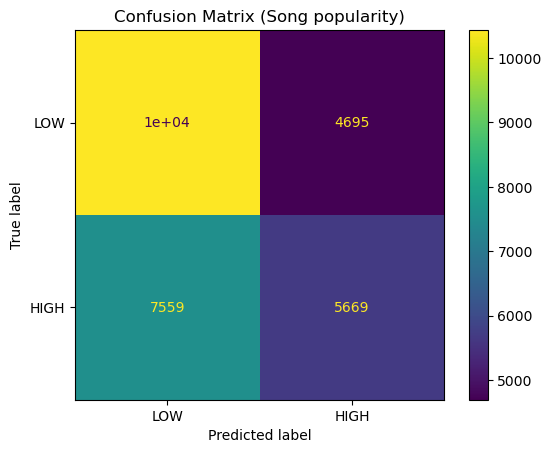

In [93]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [94]:
pred_5 = fit_and_assess_logistic(2, 'y ~ (danceability + energy + acousticness + liveness + valence + duration_ms)**2', train_data=df_modelling, threshold=0.5)
pred_5

Optimization terminated successfully.
         Current function value: 0.673991
         Iterations 5


model_name                                      model_formula  num_coefs  \
0           2  y ~ (danceability + energy + acousticness + li...         22   

   threshold  Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
0        0.5  0.567836     0.428561     0.689628  0.310372  0.597698

Let's create the ROC Curve

In [95]:
ROC_5 = fit_logistic_make_roc(5, 'y ~ (danceability + energy + acousticness + liveness + valence + duration_ms)**2', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.673991
         Iterations 5


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


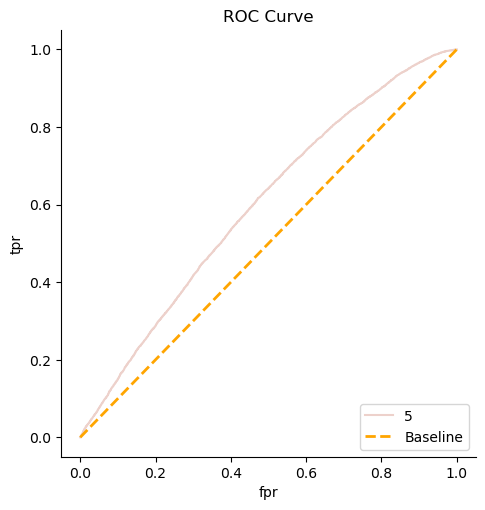

In [96]:
g = sns.relplot(data = ROC_5, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

### Model 6: Interaction of categorical inputs with continous inputs 

In [97]:
fit_glm_6 = smf.logit(formula='y ~ (key + mode + playlist_genre)*(danceability + energy + acousticness + liveness + valence + duration_ms)', data=df_modelling).fit()
fit_glm_6.summary()

Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28229
Method:                           MLE   Df Model:                          125
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.05318
Time:                        12:07:40   Log-Likelihood:                -18549.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.8276      0.060    -13.757      0.000      -0.946      -0.710
key[T.1]                                -0.0026      0.053     -0.049      0.961      -0.107       0.102
key[T.2]                                -0.0726      0.057     -1.273      0.203      -0.184       0.039
key[T.3]                                -0.0395      0.088     -0.448      0.654      -0.212       0.133
key[T.4]                                -0.0800      0.063     -1.279      0.201      -0.203       0.043
key[T.5]                                 0.0597      0.059      1.013      0.311      -0.056       0.175
key[T.6]                                 0.0136      0.059      0.229      0.819      -0.102       0.130
key[T.7]                                -0.0872      0.055     -1.600      0.110      -0.194       0.020
key[T.8]                                 0.1612      0.060      2.677      0.007       0.043       0.279
key[T.9]                                -0.0750      0.057     -1.321      0.186      -0.186       0.036
key[T.10]                                0.0504      0.062      0.813      0.416      -0.071       0.172
key[T.11]                               -0.0272      0.058     -0.474      0.636      -0.140       0.085
mode[T.1]                                0.0157      0.027      0.583      0.560      -0.037       0.068
playlist_genre[T.latin]                  0.7516      0.059     12.759      0.000       0.636       0.867
playlist_genre[T.pop]                    1.0940      0.054     20.402      0.000       0.989       1.199
playlist_genre[T.r&b]                    0.4163      0.061      6.827      0.000       0.297       0.536
playlist_genre[T.rap]                    0.6958      0.056     12.518      0.000       0.587       0.805
playlist_genre[T.rock]                   0.8673      0.067     13.026      0.000       0.737       0.998
danceability                            -0.0234      0.062     -0.375      0.707      -0.146       0.099
key[T.1]:danceability                   -0.0398      0.058     -0.681      0.496      -0.154       0.075
key[T.2]:danceability                    0.0987      0.061      1.617      0.106      -0.021       0.218
key[T.3]:danceability                   -0.2123      0.091     -2.337      0.019      -0.390      -0.034
key[T.4]:danceability                   -0.0112      0.067     -0.167      0.867      -0.142       0.120
key[T.5]:danceability                    0.0112      0.066      0.168      0.867      -0.119       0.141
key[T.6]:danceability                    0.0087      0.066      0.131      0.896      -0.121       0.138
key[T.7]:danceability                   -0.0924      0.059     -1.556      0.120      -0.209       0.024
key[T.8]:danceability                   -0.0851      0.066     -1.285      0.199      -0.215       0.045
key[T.9]:danceability                    0.0112      0.061      0.183      0.855      -0.10

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [98]:
fit_glm_6.params.shape[0]

126

In [99]:
fit_glm_6.bse

Intercept                              0.060161
key[T.1]                               0.053201
key[T.2]                               0.057018
key[T.3]                               0.088203
key[T.4]                               0.062566
                                         ...   
playlist_genre[T.latin]:duration_ms    0.052375
playlist_genre[T.pop]:duration_ms      0.051915
playlist_genre[T.r&b]:duration_ms      0.048146
playlist_genre[T.rap]:duration_ms      0.045960
playlist_genre[T.rock]:duration_ms     0.046118
Length: 126, dtype: float64

In [100]:
fit_glm_6.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept                           -0.945547 -0.709721
key[T.1]                            -0.106870  0.101674
key[T.2]                            -0.184361  0.039147
key[T.3]                            -0.212393  0.133357
key[T.4]                            -0.202619  0.042636
...                                       ...       ...
playlist_genre[T.latin]:duration_ms  0.133820  0.339125
playlist_genre[T.pop]:duration_ms   -0.027808  0.175696
playlist_genre[T.r&b]:duration_ms   -0.020372  0.168358
playlist_genre[T.rap]:duration_ms   -0.036413  0.143747
playlist_genre[T.rock]:duration_ms   0.202924  0.383702

[126 rows x 2 columns]

In [101]:
fit_glm_6.pvalues 

Intercept                              4.619877e-43
key[T.1]                               9.610476e-01
key[T.2]                               2.028770e-01
key[T.3]                               6.541277e-01
key[T.4]                               2.010721e-01
                                           ...     
playlist_genre[T.latin]:duration_ms    6.331213e-06
playlist_genre[T.pop]:duration_ms      1.543532e-01
playlist_genre[T.r&b]:duration_ms      1.243336e-01
playlist_genre[T.rap]:duration_ms      2.429330e-01
playlist_genre[T.rock]:duration_ms     2.015966e-10
Length: 126, dtype: float64

In [102]:
fit_glm_6.pvalues < 0.05

Intercept                               True
key[T.1]                               False
key[T.2]                               False
key[T.3]                               False
key[T.4]                               False
                                       ...  
playlist_genre[T.latin]:duration_ms     True
playlist_genre[T.pop]:duration_ms      False
playlist_genre[T.r&b]:duration_ms      False
playlist_genre[T.rap]:duration_ms      False
playlist_genre[T.rock]:duration_ms      True
Length: 126, dtype: bool

Display whether the significant coefficients are positive or negative

In [103]:
pd.Series(np.where(fit_glm_6.params[fit_glm_6.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_6.params[fit_glm_6.pvalues < 0.05].index)

Intercept                               NEGATIVE
key[T.8]                                POSITIVE
playlist_genre[T.latin]                 POSITIVE
playlist_genre[T.pop]                   POSITIVE
playlist_genre[T.r&b]                   POSITIVE
playlist_genre[T.rap]                   POSITIVE
playlist_genre[T.rock]                  POSITIVE
key[T.3]:danceability                   NEGATIVE
playlist_genre[T.latin]:danceability    POSITIVE
playlist_genre[T.pop]:danceability      POSITIVE
playlist_genre[T.rap]:danceability      POSITIVE
mode[T.1]:energy                        NEGATIVE
acousticness                            POSITIVE
key[T.3]:acousticness                   NEGATIVE
playlist_genre[T.pop]:acousticness      NEGATIVE
playlist_genre[T.r&b]:acousticness      NEGATIVE
playlist_genre[T.rap]:acousticness      NEGATIVE
playlist_genre[T.rock]:acousticness     NEGATIVE
mode[T.1]:liveness                      POSITIVE
playlist_genre[T.rock]:liveness         NEGATIVE
key[T.3]:valence    

In [104]:
sorted_series = fit_glm_6.params[fit_glm_6.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_6.params[sorted_series.index]

playlist_genre[T.pop]                   1.093980
playlist_genre[T.rock]                  0.867280
Intercept                              -0.827634
playlist_genre[T.latin]                 0.751582
playlist_genre[T.rap]                   0.695848
playlist_genre[T.r&b]                   0.416313
playlist_genre[T.rock]:acousticness    -0.365386
playlist_genre[T.rap]:danceability      0.343383
acousticness                            0.318494
playlist_genre[T.rock]:duration_ms      0.293313
key[T.3]:acousticness                  -0.244917
playlist_genre[T.pop]:acousticness     -0.240107
playlist_genre[T.r&b]:valence          -0.239467
playlist_genre[T.latin]:duration_ms     0.236472
key[T.3]:valence                        0.220507
duration_ms                            -0.219633
key[T.3]:danceability                  -0.212341
key[T.11]:duration_ms                  -0.193086
key[T.9]:duration_ms                   -0.180609
playlist_genre[T.pop]:danceability      0.173176
key[T.5]:duration_ms

In [105]:
fit_glm_6.params[sorted_series.index][:min(2, sorted_series.shape[0])]

playlist_genre[T.pop]     1.09398
playlist_genre[T.rock]    0.86728
dtype: float64

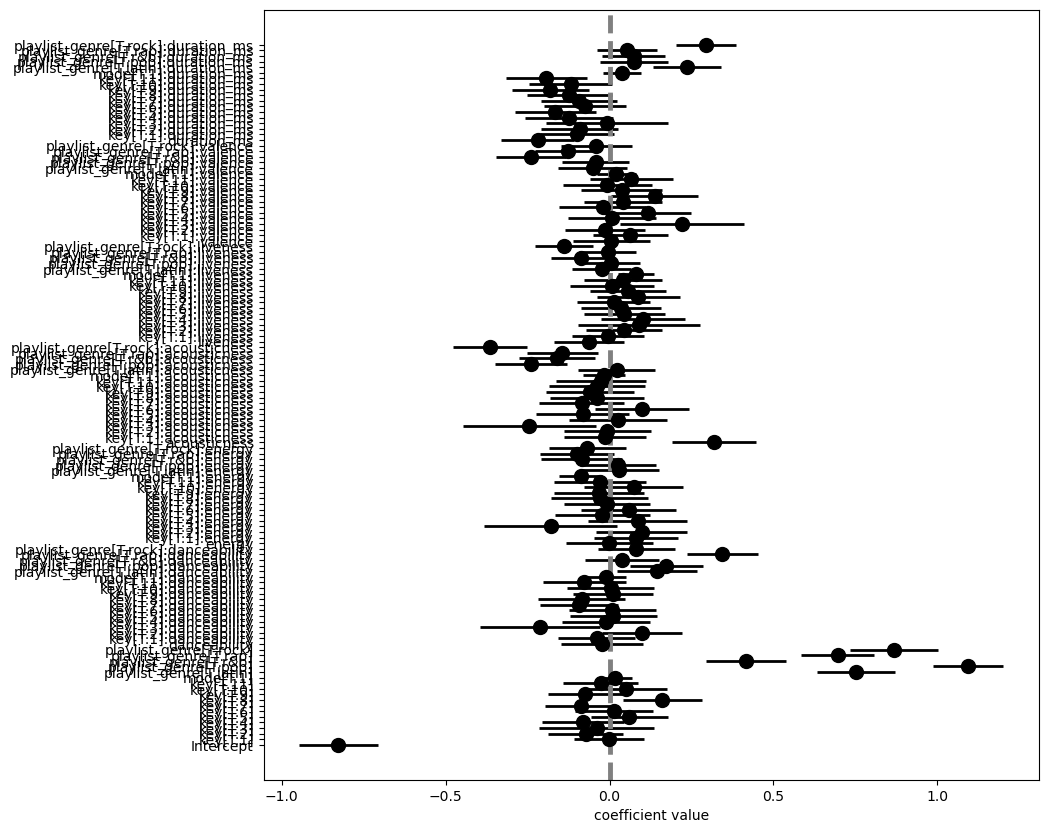

In [106]:
my_coefplot( fit_glm_6 )

In [107]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_6.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


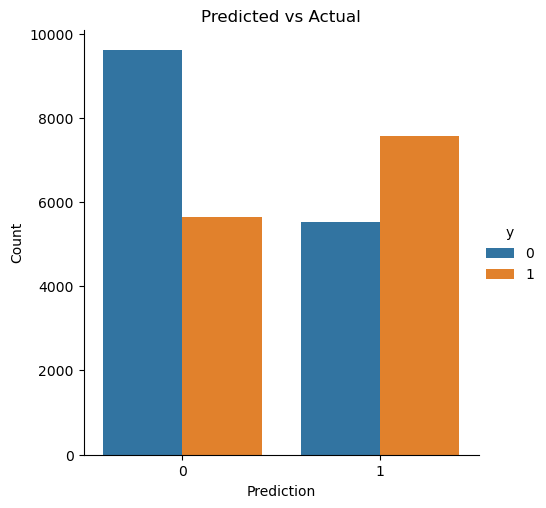

In [108]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

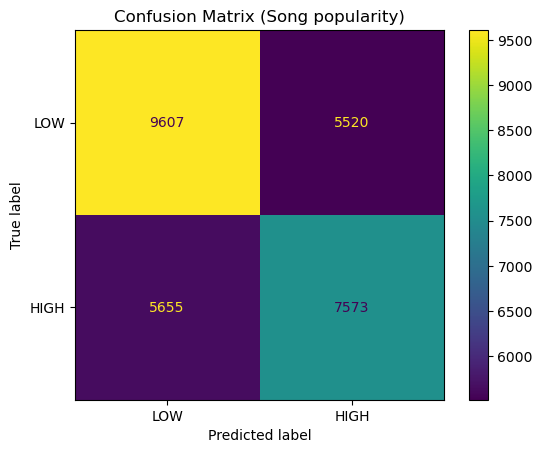

In [109]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [110]:
pred_6 = fit_and_assess_logistic(2, 'y ~ (key + mode + playlist_genre)*(danceability + energy + acousticness + liveness + valence + duration_ms)', train_data=df_modelling, threshold=0.5)
pred_6

Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 6


model_name                                      model_formula  num_coefs  \
0           2  y ~ (key + mode + playlist_genre)*(danceabilit...        126   

   threshold  Accuracy  Sensitivity  Specificity      FPR  ROC_AUC  
0        0.5   0.60589     0.572498      0.63509  0.36491  0.64819

Let's create the ROC Curve

In [111]:
ROC_6 = fit_logistic_make_roc(6, 'y ~ (key + mode + playlist_genre)*(danceability + energy + acousticness + liveness + valence + duration_ms)', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 6


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


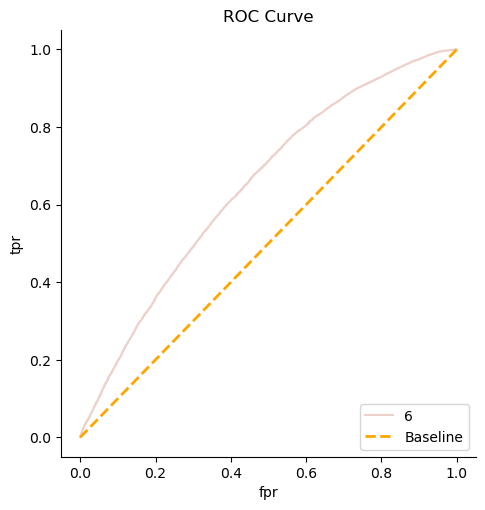

In [112]:
g = sns.relplot(data = ROC_6, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

### Model 7

In [113]:
fit_glm_7 = smf.logit(formula='y ~ (key+ mode) + (energy + acousticness)', data=df_modelling).fit()
fit_glm_7.summary()

Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28340
Method:                           MLE   Df Model:                           14
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.01083
Time:                        12:07:43   Log-Likelihood:                -19378.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                 9.973e-82
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1437      0.041     -3.481      0.000      -0.225      -0.063
key[T.1]        -0.0113      0.050     -0.224      0.823      -0.110       0.088
key[T.2]        -0.1000      0.055     -1.821      0.069      -0.208       0.008
key[T.3]        -0.0723      0.081     -0.894      0.371      -0.231       0.086
key[T.4]        -0.0532      0.060     -0.892      0.372      -0.170       0.064
key[T.5]         0.0116      0.056      0.206      0.837      -0.099       0.122
key[T.6]        -0.0243      0.057     -0.429      0.668      -0.135       0.087
key[T.7]        -0.1170      0.053     -2.225      0.026      -0.220      -0.014
key[T.8]         0.1467      0.058      2.545      0.011       0.034       0.260
key[T.9]        -0.0646      0.054     -1.194      0.233      -0.171       0.041
key[T.10]        0.0287      0.059      0.485      0.628      -0.087       0.145
key[T.11]       -0.0404      0.055     -0.735      0.462      -0.148       0.067
mode[T.1]        0.0591      0.025      2.324      0.020       0.009       0.109
energy          -0.1001      0.014     -7.137      0.000      -0.128      -0.073
acousticness     0.1685      0.014     11.982      0.000       0.141       0.196
================================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [114]:
fit_glm_7.params.shape[0]

15

In [115]:
fit_glm_7.bse

Intercept       0.041290
key[T.1]        0.050463
key[T.2]        0.054891
key[T.3]        0.080873
key[T.4]        0.059678
key[T.5]        0.056407
key[T.6]        0.056697
key[T.7]        0.052600
key[T.8]        0.057640
key[T.9]        0.054128
key[T.10]       0.059203
key[T.11]       0.055011
mode[T.1]       0.025439
energy          0.014020
acousticness    0.014066
dtype: float64

In [116]:
fit_glm_7.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept    -0.224666 -0.062814
key[T.1]     -0.110223  0.087587
key[T.2]     -0.207556  0.007612
key[T.3]     -0.230789  0.086230
key[T.4]     -0.170204  0.063729
key[T.5]     -0.098942  0.122169
key[T.6]     -0.135420  0.086827
key[T.7]     -0.220128 -0.013940
key[T.8]      0.033709  0.259652
key[T.9]     -0.170698  0.041479
key[T.10]    -0.087315  0.144757
key[T.11]    -0.148241  0.067398
mode[T.1]     0.009259  0.108979
energy       -0.127541 -0.072584
acousticness  0.140979  0.196117

In [117]:
fit_glm_7.pvalues 

Intercept       4.990359e-04
key[T.1]        8.225348e-01
key[T.2]        6.856357e-02
key[T.3]        3.714640e-01
key[T.4]        3.723496e-01
key[T.5]        8.368818e-01
key[T.6]        6.682600e-01
key[T.7]        2.608188e-02
key[T.8]        1.093474e-02
key[T.9]        2.326158e-01
key[T.10]       6.275855e-01
key[T.11]       4.624659e-01
mode[T.1]       2.012930e-02
energy          9.523633e-13
acousticness    4.393476e-33
dtype: float64

In [118]:
fit_glm_7.pvalues < 0.05

Intercept        True
key[T.1]        False
key[T.2]        False
key[T.3]        False
key[T.4]        False
key[T.5]        False
key[T.6]        False
key[T.7]         True
key[T.8]         True
key[T.9]        False
key[T.10]       False
key[T.11]       False
mode[T.1]        True
energy           True
acousticness     True
dtype: bool

Display whether the significant coefficients are positive or negative

In [119]:
pd.Series(np.where(fit_glm_7.params[fit_glm_7.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_7.params[fit_glm_7.pvalues < 0.05].index)

Intercept       NEGATIVE
key[T.7]        NEGATIVE
key[T.8]        POSITIVE
mode[T.1]       POSITIVE
energy          NEGATIVE
acousticness    POSITIVE
dtype: object

In [120]:
sorted_series = fit_glm_7.params[fit_glm_7.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_7.params[sorted_series.index]

acousticness    0.168548
key[T.8]        0.146681
Intercept      -0.143740
key[T.7]       -0.117034
energy         -0.100062
mode[T.1]       0.059119
dtype: float64

In [121]:
fit_glm_7.params[sorted_series.index][:min(2, sorted_series.shape[0])]

acousticness    0.168548
key[T.8]        0.146681
dtype: float64

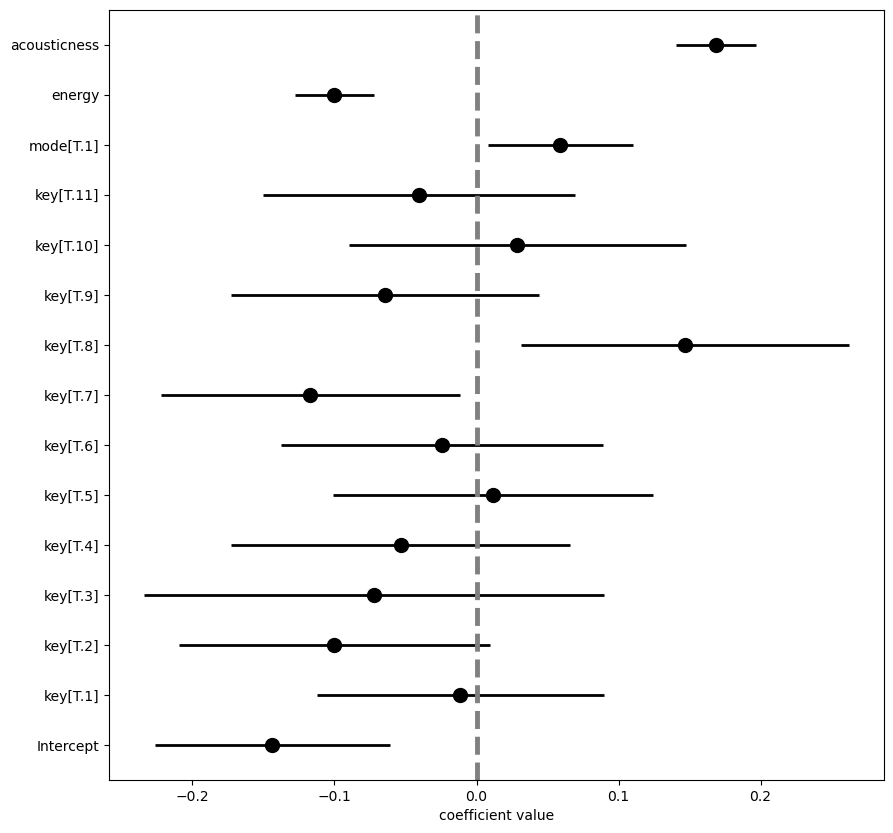

In [122]:
my_coefplot( fit_glm_7 )

Now let us predict using the model and the dataset.

In [123]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_7.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


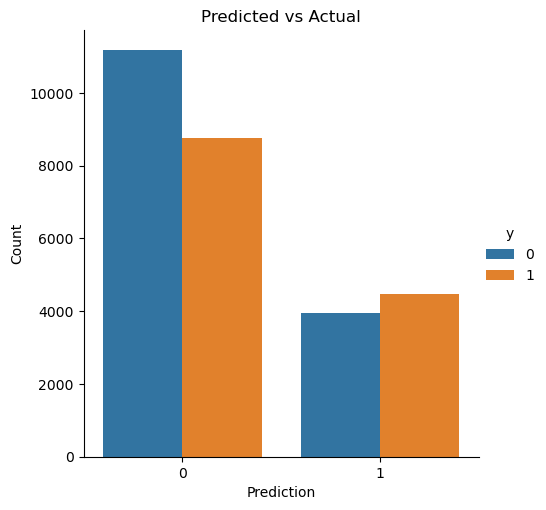

In [124]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

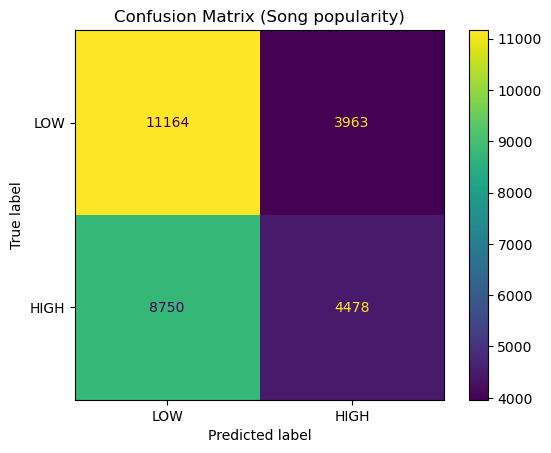

In [125]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [126]:
pred_7 = fit_and_assess_logistic(7, 'y ~ (key+ mode)+(energy + acousticness)', train_data=df_modelling, threshold=0.5)
pred_7

Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 4


model_name                            model_formula  num_coefs  threshold  \
0           7  y ~ (key+ mode)+(energy + acousticness)         15        0.5   

   Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
0  0.551649     0.338524     0.738018  0.261982  0.571017

Let's create the ROC Curve

In [127]:
ROC_7 = fit_logistic_make_roc(7, 'y ~ (key+ mode)+(energy + acousticness)', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 4


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


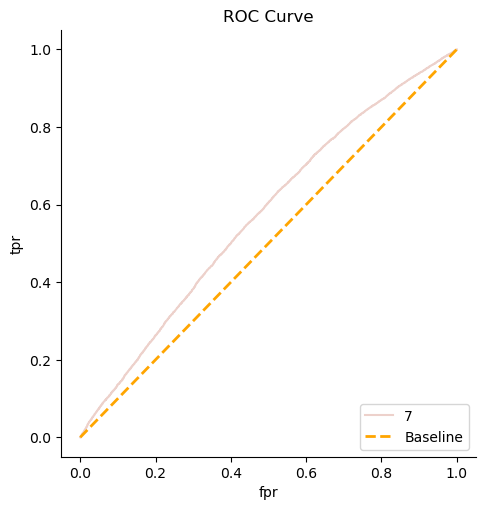

In [128]:
g = sns.relplot(data = ROC_7, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

## Model 8

In [129]:
fit_glm_8 = smf.logit(formula='y ~ playlist_genre * (danceability + valence)', data=df_modelling).fit()
fit_glm_8.summary()

Optimization terminated successfully.
         Current function value: 0.666499
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                28355
Model:                          Logit   Df Residuals:                    28337
Method:                           MLE   Df Model:                           17
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.03532
Time:                        12:07:44   Log-Likelihood:                -18899.
converged:                       True   LL-Null:                       -19591.
Covariance Type:            nonrobust   LLR p-value:                4.336e-284
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.8948      0.036    -25.073      0.000      -0.965      -0.825
playlist_genre[T.latin]                  0.9173      0.050     18.169      0.000       0.818       1.016
playlist_genre[T.pop]                    1.1907      0.046     26.063      0.000       1.101       1.280
playlist_genre[T.r&b]                    0.5693      0.047     12.108      0.000       0.477       0.662
playlist_genre[T.rap]                    0.8655      0.047     18.412      0.000       0.773       0.958
playlist_genre[T.rock]                   0.9500      0.059     16.061      0.000       0.834       1.066
danceability                            -0.1295      0.041     -3.169      0.002      -0.210      -0.049
playlist_genre[T.latin]:danceability     0.1883      0.058      3.239      0.001       0.074       0.302
playlist_genre[T.pop]:danceability       0.2742      0.053      5.137      0.000       0.170       0.379
playlist_genre[T.r&b]:danceability       0.1055      0.054      1.956      0.050      -0.000       0.211
playlist_genre[T.rap]:danceability       0.4455      0.051      8.688      0.000       0.345       0.546
playlist_genre[T.rock]:danceability      0.2060      0.055      3.740      0.000       0.098       0.314
valence                                  0.1654      0.036      4.652      0.000       0.096       0.235
playlist_genre[T.latin]:valence         -0.1344      0.050     -2.713      0.007      -0.232      -0.037
playlist_genre[T.pop]:valence           -0.1461      0.048     -3.051      0.002      -0.240      -0.052
playlist_genre[T.r&b]:valence           -0.4019      0.050     -8.082      0.000      -0.499      -0.304
playlist_genre[T.rap]:valence           -0.2883      0.046     -6.222      0.000      -0.379      -0.197
playlist_genre[T.rock]:valence          -0.1891      0.051     -3.731      0.000      -0.288      -0.090
========================================================================================================
"""

Display the number of coefficients predicted, standard error on the mean for each coefficient, Confidence error for each coefficient and which coefficients are statistically significant.

In [130]:
fit_glm_8.params.shape[0]

18

In [131]:
fit_glm_8.bse

Intercept                               0.035687
playlist_genre[T.latin]                 0.050487
playlist_genre[T.pop]                   0.045685
playlist_genre[T.r&b]                   0.047023
playlist_genre[T.rap]                   0.047006
playlist_genre[T.rock]                  0.059149
danceability                            0.040873
playlist_genre[T.latin]:danceability    0.058148
playlist_genre[T.pop]:danceability      0.053376
playlist_genre[T.r&b]:danceability      0.053920
playlist_genre[T.rap]:danceability      0.051280
playlist_genre[T.rock]:danceability     0.055069
valence                                 0.035552
playlist_genre[T.latin]:valence         0.049557
playlist_genre[T.pop]:valence           0.047888
playlist_genre[T.r&b]:valence           0.049727
playlist_genre[T.rap]:valence           0.046330
playlist_genre[T.rock]:valence          0.050686
dtype: float64

In [132]:
fit_glm_8.conf_int().rename(columns={0: 'lower', 1: 'upper'})

lower     upper
Intercept                            -0.964716 -0.824826
playlist_genre[T.latin]               0.818332  1.016239
playlist_genre[T.pop]                 1.101149  1.280229
playlist_genre[T.r&b]                 0.477185  0.661511
playlist_genre[T.rap]                 0.773339  0.957600
playlist_genre[T.rock]                0.834073  1.065934
danceability                         -0.209652 -0.049434
playlist_genre[T.latin]:danceability  0.074350  0.302286
playlist_genre[T.pop]:danceability    0.169582  0.378811
playlist_genre[T.r&b]:danceability   -0.000196  0.211166
playlist_genre[T.rap]:danceability    0.345022  0.546038
playlist_genre[T.rock]:danceability   0.098022  0.313887
valence                               0.095694  0.235054
playlist_genre[T.latin]:valence      -0.231579 -0.037317
playlist_genre[T.pop]:valence        -0.239984 -0.052266
playlist_genre[T.r&b]:valence        -0.499351 -0.304423
playlist_genre[T.rap]:valence        -0.379059 -0.197449
playlist_genre[T.rock]:valence       -0.288434 -0.089748

In [133]:
fit_glm_8.pvalues 

Intercept                               9.831446e-139
playlist_genre[T.latin]                  9.150464e-74
playlist_genre[T.pop]                   9.507292e-150
playlist_genre[T.r&b]                    9.589532e-34
playlist_genre[T.rap]                    1.056304e-75
playlist_genre[T.rock]                   4.778661e-58
danceability                             1.527348e-03
playlist_genre[T.latin]:danceability     1.201158e-03
playlist_genre[T.pop]:danceability       2.790177e-07
playlist_genre[T.r&b]:danceability       5.042641e-02
playlist_genre[T.rap]:danceability       3.685018e-18
playlist_genre[T.rock]:danceability      1.840452e-04
valence                                  3.293080e-06
playlist_genre[T.latin]:valence          6.668237e-03
playlist_genre[T.pop]:valence            2.277977e-03
playlist_genre[T.r&b]:valence            6.381609e-16
playlist_genre[T.rap]:valence            4.916630e-10
playlist_genre[T.rock]:valence           1.910100e-04
dtype: float64

In [134]:
fit_glm_8.pvalues < 0.05

Intercept                                True
playlist_genre[T.latin]                  True
playlist_genre[T.pop]                    True
playlist_genre[T.r&b]                    True
playlist_genre[T.rap]                    True
playlist_genre[T.rock]                   True
danceability                             True
playlist_genre[T.latin]:danceability     True
playlist_genre[T.pop]:danceability       True
playlist_genre[T.r&b]:danceability      False
playlist_genre[T.rap]:danceability       True
playlist_genre[T.rock]:danceability      True
valence                                  True
playlist_genre[T.latin]:valence          True
playlist_genre[T.pop]:valence            True
playlist_genre[T.r&b]:valence            True
playlist_genre[T.rap]:valence            True
playlist_genre[T.rock]:valence           True
dtype: bool

Display whether the significant coefficients are positive or negative

In [135]:
pd.Series(np.where(fit_glm_2.params[fit_glm_2.pvalues < 0.05] < 0, 'NEGATIVE', 'POSITIVE'), index=fit_glm_2.params[fit_glm_2.pvalues < 0.05].index)

Intercept                  NEGATIVE
key[T.2]                   NEGATIVE
key[T.7]                   NEGATIVE
key[T.8]                   POSITIVE
playlist_genre[T.latin]    POSITIVE
playlist_genre[T.pop]      POSITIVE
playlist_genre[T.r&b]      POSITIVE
playlist_genre[T.rap]      POSITIVE
playlist_genre[T.rock]     POSITIVE
dtype: object

In [136]:
sorted_series = fit_glm_8.params[fit_glm_8.pvalues < 0.05].abs().sort_values(ascending=False)
fit_glm_8.params[sorted_series.index]

playlist_genre[T.pop]                   1.190689
playlist_genre[T.rock]                  0.950004
playlist_genre[T.latin]                 0.917286
Intercept                              -0.894771
playlist_genre[T.rap]                   0.865470
playlist_genre[T.r&b]                   0.569348
playlist_genre[T.rap]:danceability      0.445530
playlist_genre[T.r&b]:valence          -0.401887
playlist_genre[T.rap]:valence          -0.288254
playlist_genre[T.pop]:danceability      0.274197
playlist_genre[T.rock]:danceability     0.205955
playlist_genre[T.rock]:valence         -0.189091
playlist_genre[T.latin]:danceability    0.188318
valence                                 0.165374
playlist_genre[T.pop]:valence          -0.146125
playlist_genre[T.latin]:valence        -0.134448
danceability                           -0.129543
dtype: float64

In [137]:
fit_glm_8.params[sorted_series.index][:min(2, sorted_series.shape[0])]

playlist_genre[T.pop]     1.190689
playlist_genre[T.rock]    0.950004
dtype: float64

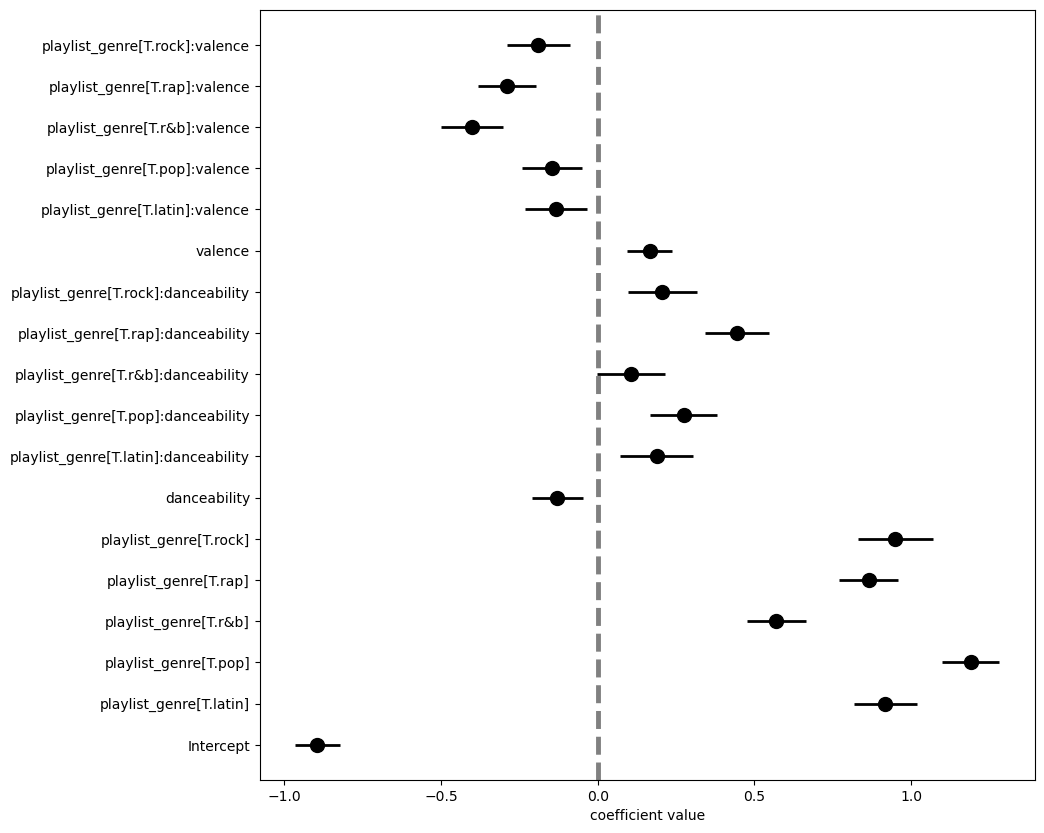

In [138]:
my_coefplot( fit_glm_8 )

Now let us predict using the model and the dataset.

In [139]:
df_predicted = df_modelling.copy()
df_predicted ['pred_probability'] = fit_glm_8.predict( df_modelling )
threshold = 0.5
df_predicted ['pred_class'] = np.where( df_predicted.pred_probability > threshold, 1, 0)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


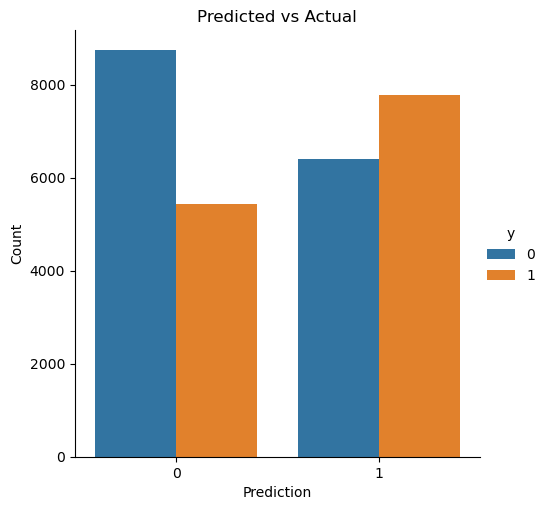

In [140]:
sns.catplot(data=df_predicted, x='pred_class', hue='y', kind='count')
plt.title('Predicted vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

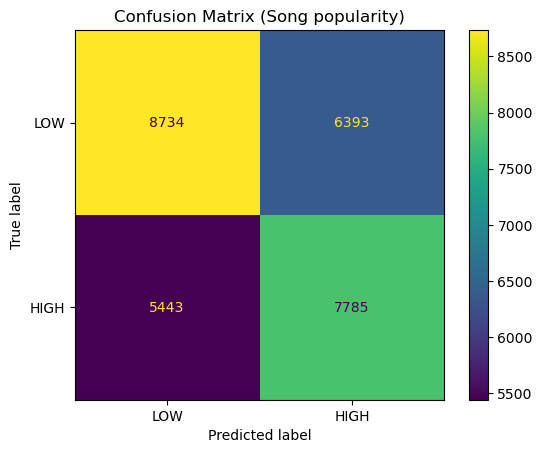

In [141]:
conf_matrix = confusion_matrix(df_predicted.y.to_numpy(), df_predicted.pred_class.to_numpy())
ConfusionMatrixDisplay(conf_matrix, display_labels=['LOW', 'HIGH']).plot()
plt.title('Confusion Matrix (Song popularity)')
plt.grid(False)
plt.show()

Let's use the function created earlier to see the performance values

In [142]:
pred_8 = fit_and_assess_logistic(8, 'y ~ playlist_genre * (danceability + valence)', train_data=df_modelling, threshold=0.5)
pred_8

Optimization terminated successfully.
         Current function value: 0.666499
         Iterations 5


model_name                                  model_formula  num_coefs  \
0           8  y ~ playlist_genre * (danceability + valence)         18   

   threshold  Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
0        0.5  0.582578     0.588524     0.577378  0.422622  0.620144

Let's create the ROC Curve

In [143]:
ROC_8 = fit_logistic_make_roc(8, 'y ~ playlist_genre * (danceability + valence)', train_data=df_modelling)

Optimization terminated successfully.
         Current function value: 0.666499
         Iterations 5


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


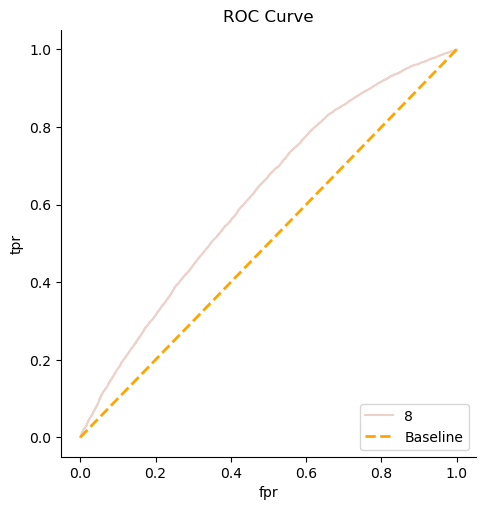

In [144]:
g = sns.relplot(data = ROC_8, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None , color='green')
g._legend.remove()
ax = g.ax
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=2, label='Baseline')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.set_title('ROC Curve')
plt.show()

Now let's take a look at all the models within one dataframe.

In [145]:
formula_list = ['y ~ 1', # Intercept only
                'y ~ key + mode + playlist_genre', # Categorical additive
                'y ~ danceability + energy + acousticness + liveness + valence + duration_ms', # Continous additive 
                'y ~ key + mode + playlist_genre + danceability + energy + acousticness + liveness + valence + duration_ms', #All inputs with linear additive features
                'y ~ (danceability + energy + acousticness + liveness + valence + duration_ms)**2',# Continous inputs with linear main effect and pair-wise interactions
                'y ~ (key + mode + playlist_genre)*(danceability + energy + acousticness + liveness + valence + duration_ms)', #Interactive categorical and continous
                'y ~ (key+ mode) + (energy + acousticness)', #Model choice 1
                'y ~ playlist_genre * (danceability + valence)'] #Model choice 2

In [146]:
results_list = []

for m in range(len(formula_list)):
    results_list.append( fit_and_assess_logistic(m+1, formula_list[m], train_data= df_modelling, threshold=0.5))

Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666499
         Iterations 5


In [147]:
results_df = pd.concat( results_list, ignore_index=True) 
results_df.sort_values(by=['ROC_AUC'], ascending=False)

model_name                                      model_formula  num_coefs  \
5           6  y ~ (key + mode + playlist_genre)*(danceabilit...        126   
3           4  y ~ key + mode + playlist_genre + danceability...         24   
7           8      y ~ playlist_genre * (danceability + valence)         18   
1           2                    y ~ key + mode + playlist_genre         18   
4           5  y ~ (danceability + energy + acousticness + li...         22   
2           3  y ~ danceability + energy + acousticness + liv...          7   
6           7          y ~ (key+ mode) + (energy + acousticness)         15   
0           1                                              y ~ 1          1   

   threshold  Accuracy  Sensitivity  Specificity       FPR   ROC_AUC  
5        0.5  0.605890     0.572498     0.635090  0.364910  0.648190  
3        0.5  0.593476     0.553750     0.628214  0.371786  0.631902  
7        0.5  0.582578     0.588524     0.577378  0.422622  0.620144  
1        0.5  0.574467     0.616117     0.538045  0.461955  0.608519  
4        0.5  0.567836     0.428561     0.689628  0.310372  0.597698  
2        0.5  0.560818     0.389779     0.710385  0.289615  0.586903  
6        0.5  0.551649     0.338524     0.738018  0.261982  0.571017  
0        0.5  0.533486     0.000000     1.000000  0.000000  0.500000

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


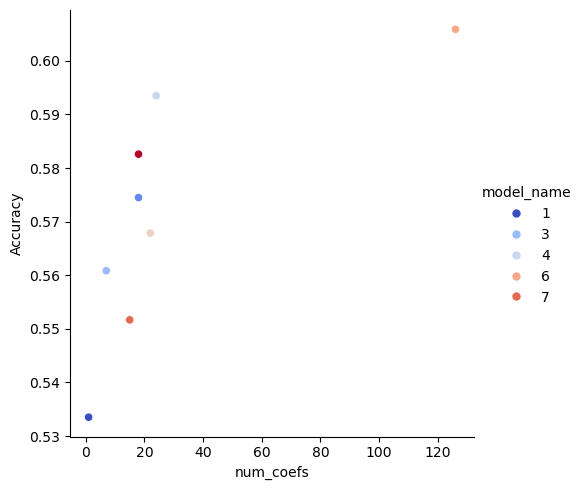

In [148]:
sns.relplot(data = results_df, x='num_coefs', y='Accuracy', hue='model_name', kind='scatter', legend=True,palette='coolwarm')

plt.show()

In [149]:
roc_list = []

for m in range( len(formula_list)):
    roc_list.append( fit_logistic_make_roc(m+1, formula_list[m], train_data= df_modelling))

Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666499
         Iterations 5


In [150]:
roc_df = pd.concat( roc_list, ignore_index=True )

In [151]:
roc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83182 entries, 0 to 83181
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tpr            83182 non-null  float64
 1   fpr            83182 non-null  float64
 2   threshold      83182 non-null  float64
 3   model_name     83182 non-null  int64  
 4   model_formula  83182 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 3.2+ MB


In [152]:
roc_df['model_name'] = roc_df.model_name.astype('category')

In [153]:
roc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83182 entries, 0 to 83181
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tpr            83182 non-null  float64 
 1   fpr            83182 non-null  float64 
 2   threshold      83182 non-null  float64 
 3   model_name     83182 non-null  category
 4   model_formula  83182 non-null  object  
dtypes: category(1), float64(3), object(1)
memory usage: 2.6+ MB


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


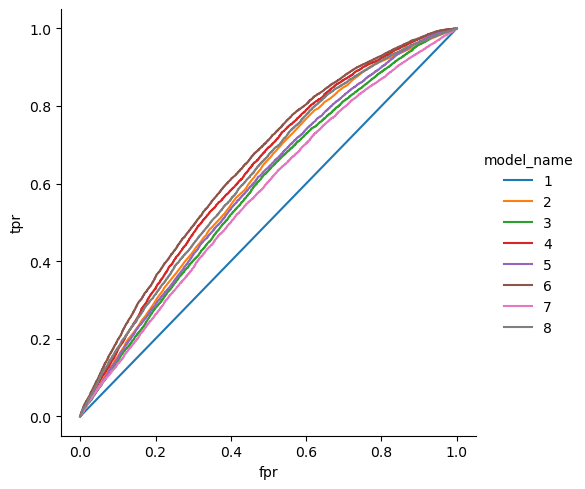

In [154]:
sns.relplot(data = roc_df, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None, units='model_name')

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


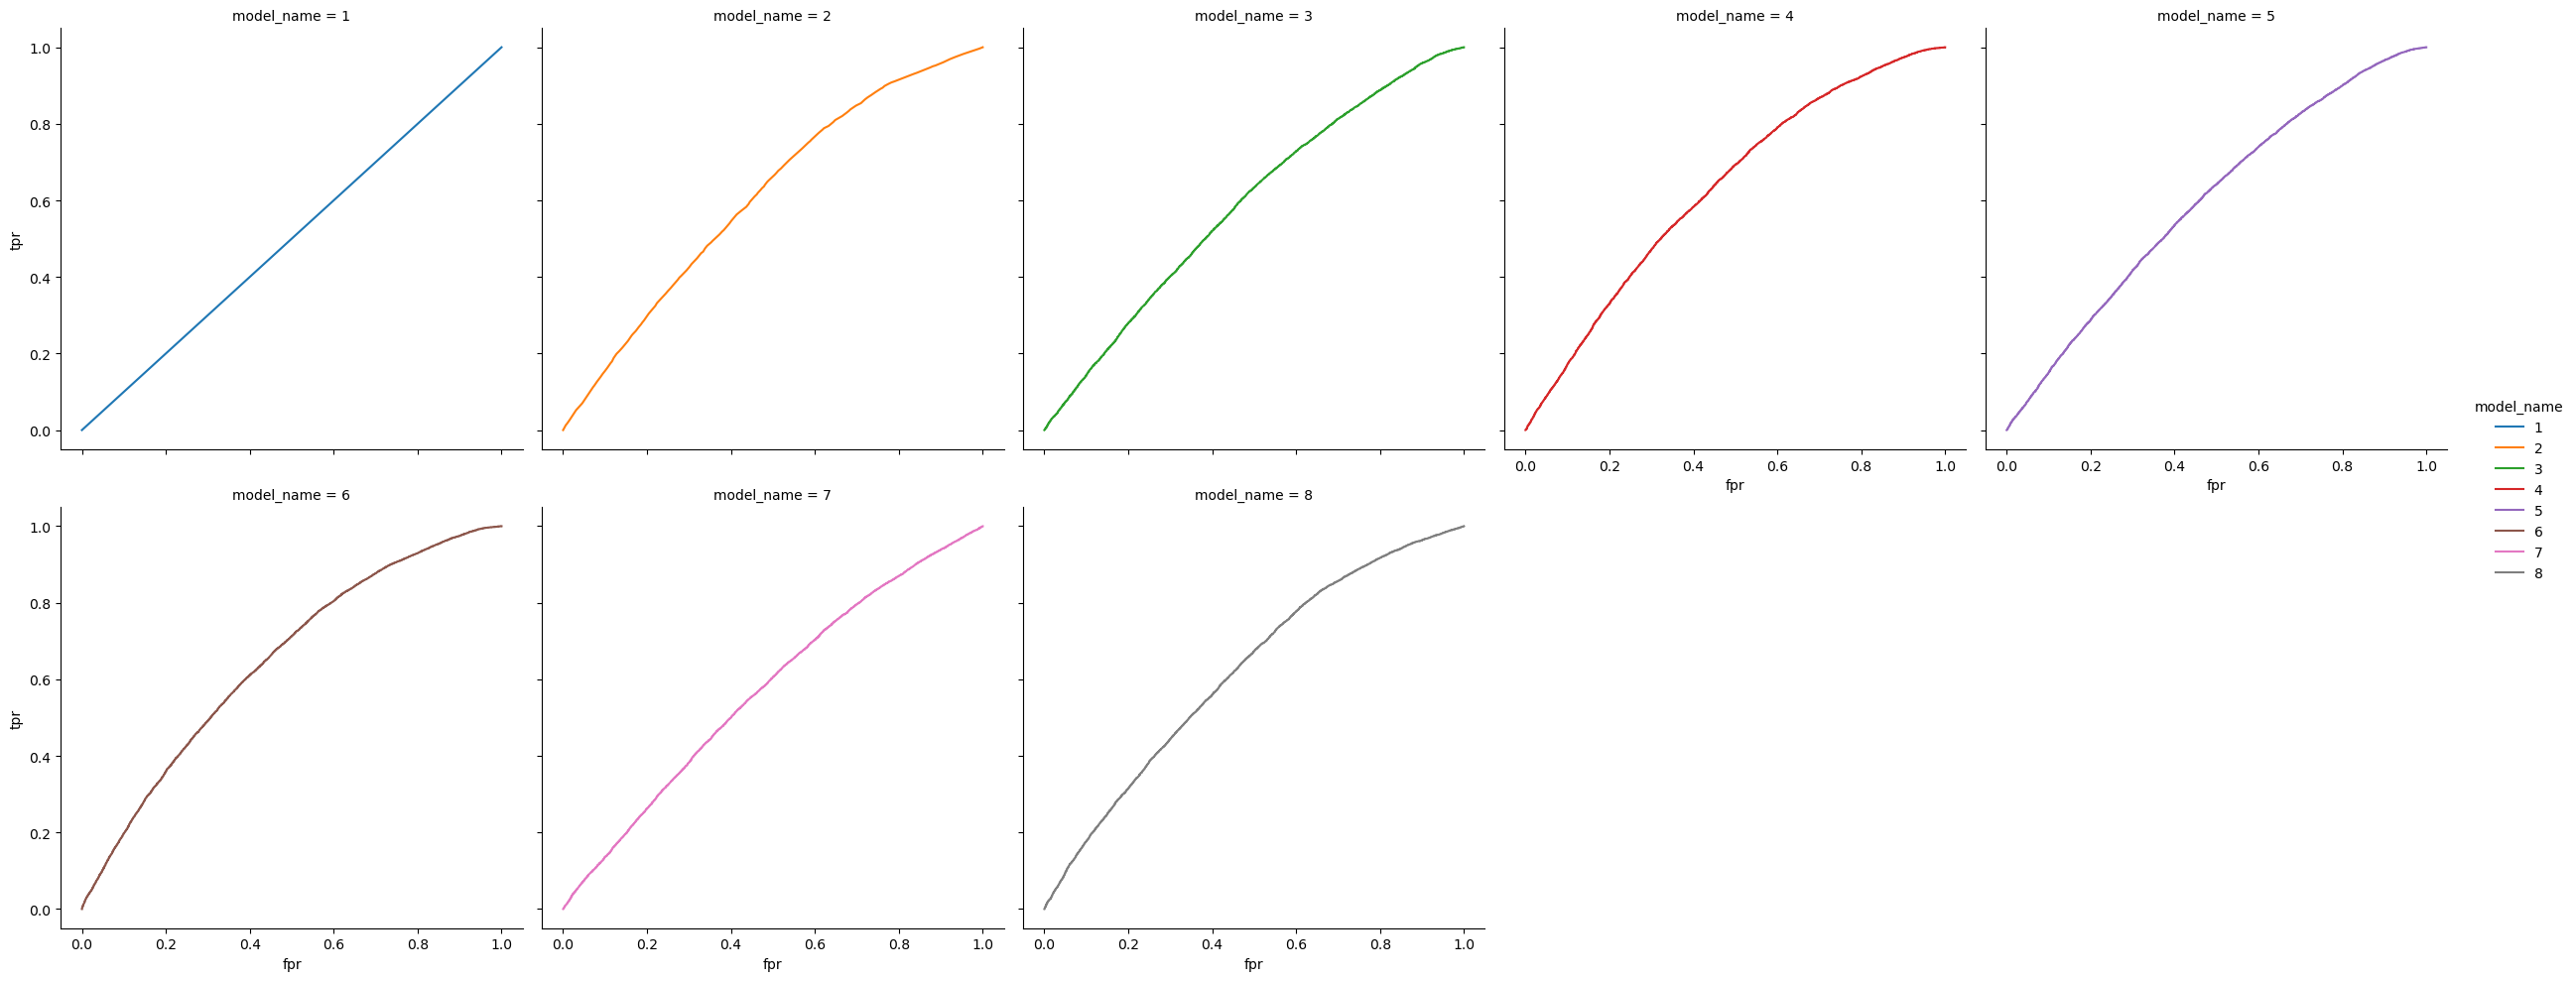

In [155]:
sns.relplot(data = roc_df, x='fpr', y='tpr', hue='model_name', 
            kind='line', estimator=None, units='model_name',
            col='model_name', col_wrap=5)

plt.show()

## Predictions 

We will make predictions using 2 models, those being the all inputs model and the model with the best performance, which were model 4 and model 6 respectively. First lets create the input grid for the all inputs model.

### All inputs model

In [156]:
formula_list[4-1]

'y ~ key + mode + playlist_genre + danceability + energy + acousticness + liveness + valence + duration_ms'

In [157]:
all_inputs_model = smf.logit(formula_list[4-1], data=df_modelling).fit()

Optimization terminated successfully.
         Current function value: 0.661513
         Iterations 5


In [158]:
sorted_series = all_inputs_model.params[all_inputs_model.pvalues < 0.05].abs().sort_values(ascending=False)
all_inputs_model.params[sorted_series.index]

playlist_genre[T.pop]      1.156200
playlist_genre[T.rock]     1.089056
Intercept                 -0.889852
playlist_genre[T.rap]      0.887439
playlist_genre[T.latin]    0.875088
playlist_genre[T.r&b]      0.486549
duration_ms               -0.201505
key[T.8]                   0.160813
acousticness               0.122771
danceability               0.073770
energy                    -0.065805
valence                   -0.030647
dtype: float64

In [159]:
input_grid_all = pd.DataFrame((playlist_genre, acousticness, danceability, energy, key, mode, liveness, valence, duration_ms) 
                                    for playlist_genre in df_modelling.playlist_genre.unique()
                                    for acousticness in np.linspace(df_modelling.acousticness.min(), df_modelling.acousticness.max(), num=101)
                                    for danceability in np.linspace(df_modelling.danceability.min(), df_modelling.danceability.max(), num=5)
                                    for energy in [df_modelling.energy.mean()]
                                    for key in [df_modelling.key.value_counts().sort_index().index[0]]
                                    for mode in [df_modelling['mode'].value_counts().sort_index().index[0]]
                                    for liveness in [df_modelling.liveness.mean()]
                                    for valence in [df_modelling.valence.mean()]
                                    for duration_ms in [df_modelling.duration_ms.mean()])
input_grid_all.columns=['playlist_genre', 'acousticness', 'danceability', 'energy', 'key', 'mode', 'liveness', 'valence', 'duration_ms']

In [160]:
df_viz_all = df_modelling.copy()
df_viz_all['pred_probability_all'] = all_inputs_model.predict( input_grid_all )

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


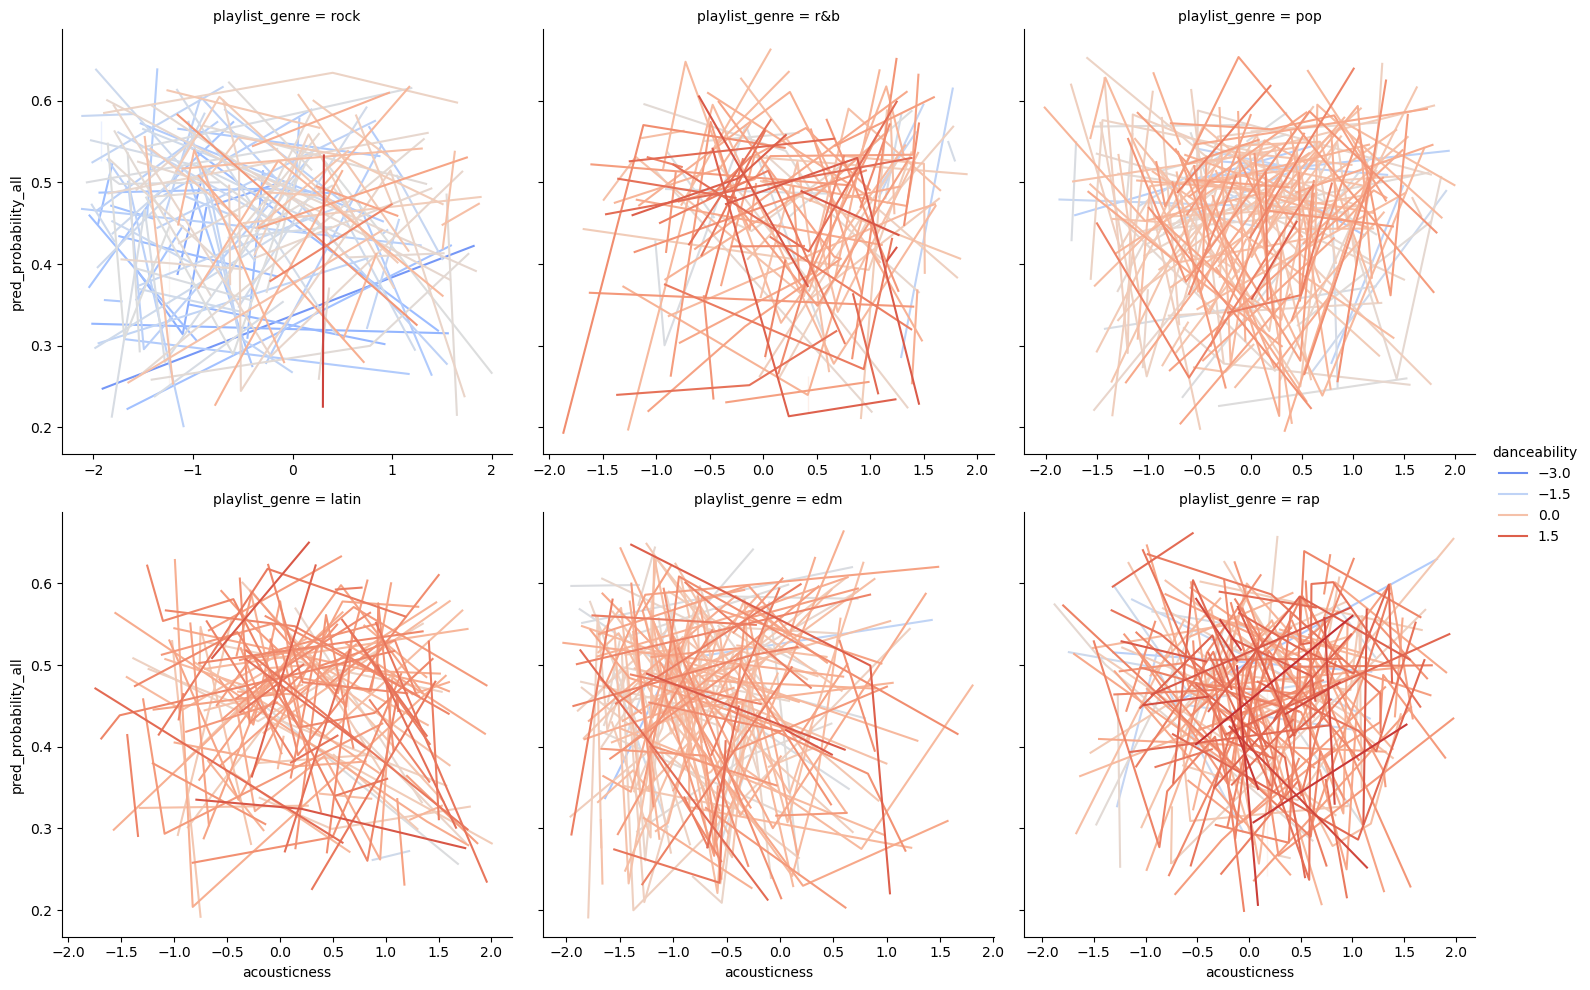

In [161]:
sns.relplot(data = df_viz_all, x = 'acousticness', y='pred_probability_all', hue = 'danceability', col = 'playlist_genre', 
            palette='coolwarm', col_wrap = 3, kind='line', facet_kws={'sharex': False})
plt.show()

This model is very complex as there is a large amount of variability across all genres. There seems to be a lower `danceability` values across rock genres compared to the other genres.

Now let's predict using the best model (based on ROC_AUC score) which was model 6.

### Model with best ROC_AUC

In [162]:
formula_list[6-1]

'y ~ (key + mode + playlist_genre)*(danceability + energy + acousticness + liveness + valence + duration_ms)'

In [163]:
best_model = smf.logit(formula_list[6-1], data=df_modelling).fit()

Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 6


In [164]:
sorted_series = best_model.params[best_model.pvalues < 0.05].abs().sort_values(ascending=False)
best_model.params[sorted_series.index]

playlist_genre[T.pop]                   1.093980
playlist_genre[T.rock]                  0.867280
Intercept                              -0.827634
playlist_genre[T.latin]                 0.751582
playlist_genre[T.rap]                   0.695848
playlist_genre[T.r&b]                   0.416313
playlist_genre[T.rock]:acousticness    -0.365386
playlist_genre[T.rap]:danceability      0.343383
acousticness                            0.318494
playlist_genre[T.rock]:duration_ms      0.293313
key[T.3]:acousticness                  -0.244917
playlist_genre[T.pop]:acousticness     -0.240107
playlist_genre[T.r&b]:valence          -0.239467
playlist_genre[T.latin]:duration_ms     0.236472
key[T.3]:valence                        0.220507
duration_ms                            -0.219633
key[T.3]:danceability                  -0.212341
key[T.11]:duration_ms                  -0.193086
key[T.9]:duration_ms                   -0.180609
playlist_genre[T.pop]:danceability      0.173176
key[T.5]:duration_ms

The most influential variables for this model are `playlist_genre`, `acousticness` and `key`.

In [165]:
input_grid_best = pd.DataFrame((playlist_genre, acousticness, key, danceability, energy, mode, liveness, valence, duration_ms) 
                                    for playlist_genre in df_modelling.playlist_genre.unique()
                                    for acousticness in np.linspace(df_modelling.acousticness.min(), df_modelling.acousticness.max(), num=101)
                                    for key in df_modelling.key.unique()
                                    for danceability in [df_modelling.danceability.mean()]
                                    for energy in [df_modelling.energy.mean()]
                                    for mode in [df_modelling['mode'].value_counts().sort_index().index[0]]
                                    for liveness in [df_modelling.liveness.mean()]
                                    for valence in [df_modelling.valence.mean()]
                                    for duration_ms in [df_modelling.duration_ms.mean()])
input_grid_best.columns=['playlist_genre', 'acousticness', 'key', 'danceability', 'energy', 'mode', 'liveness', 'valence', 'duration_ms']

In [166]:
df_viz_best = df_modelling.copy()
df_viz_best['pred_probability_best'] = best_model.predict( input_grid_best )

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


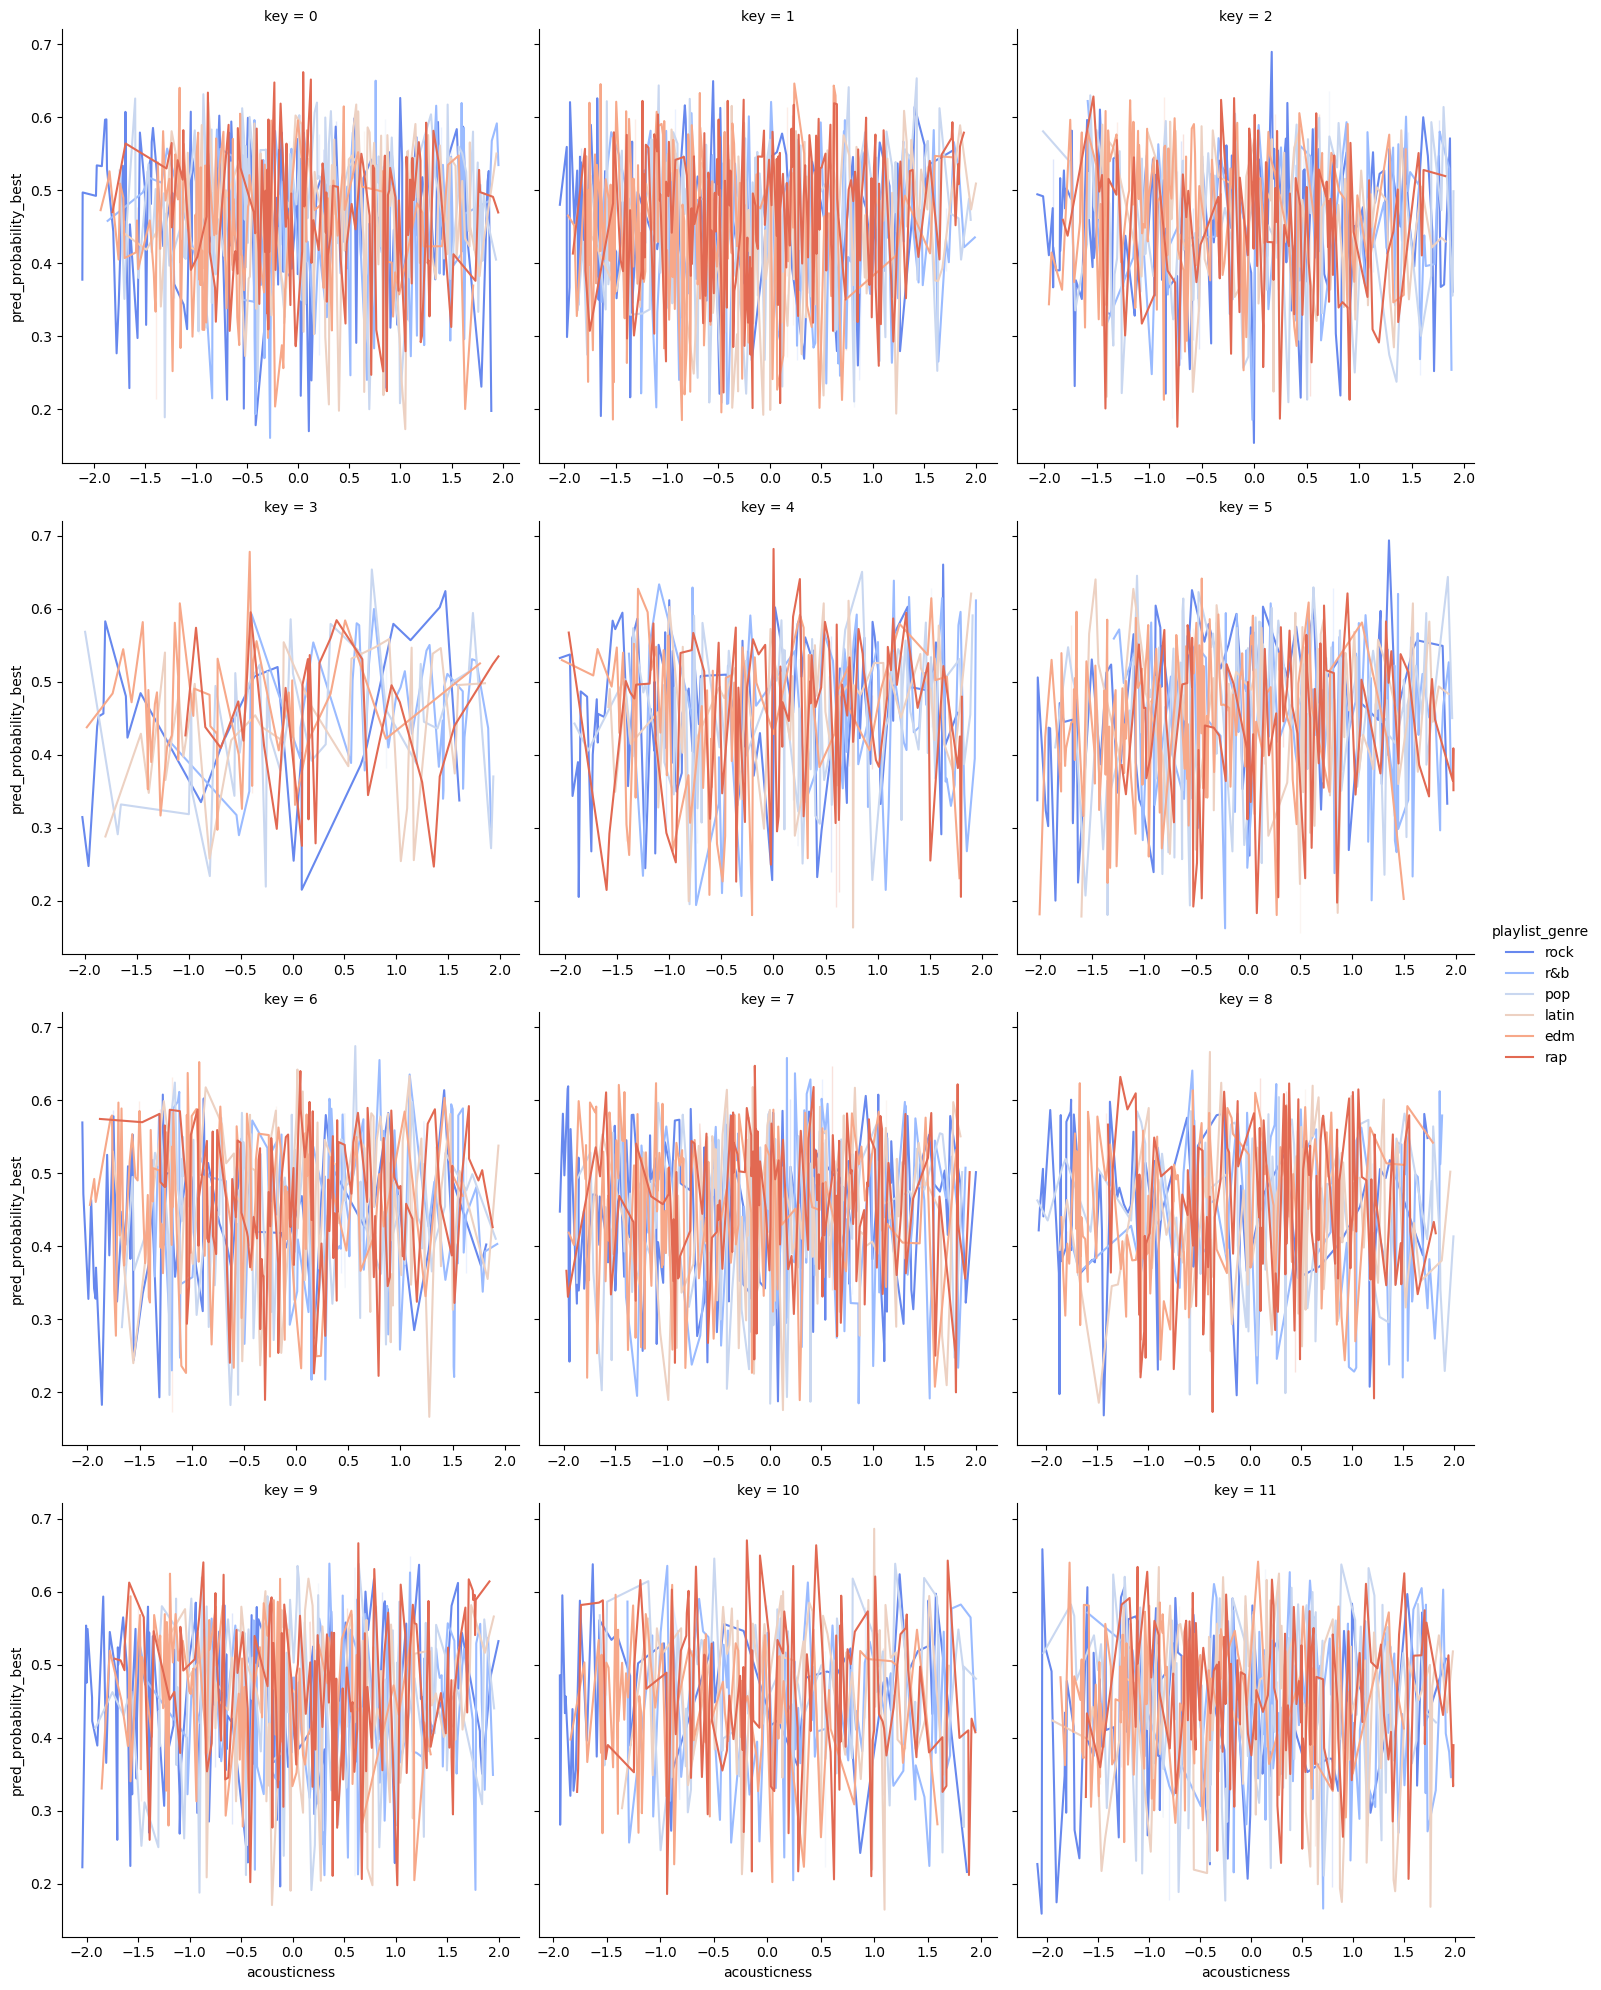

In [167]:
sns.relplot(data = df_viz_best, x = 'acousticness', y='pred_probability_best', hue = 'playlist_genre', col = 'key', 
            palette='coolwarm', col_wrap = 3, kind='line', facet_kws={'sharex': False})
plt.show()

This model is very complex as there is a large amount of variability across all genres and key's. There seems to be a less `acousticness` values in `key = 3` compared to the other key's 